# Initial Inspection and Data Prep

## imports

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates as mdates
import matplotlib.ticker as mticks
import holidays
import datetime as dt
from holidays import country_holidays
from matplotlib import ticker
import statsmodels.tsa.api as tsa
from statsmodels.tools.tools import add_constant
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
import pmdarima as pm
import os
import warnings
warnings.filterwarnings('ignore')

## Functions

In [10]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [11]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [12]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

## Importing Data & Initial Inspection

In [206]:
# Importing data cleaned in the other notebook
chicago_clean = pd.read_csv('Data/clean-chicago-data.csv.gz')

In [207]:
chicago_clean

Unnamed: 0                    Date        Primary Type  \
0                 0  01/01/2001 01:00:00 AM             BATTERY   
1                 1  01/01/2001 01:00:00 PM             BATTERY   
2                 2  01/01/2001 01:00:00 PM            GAMBLING   
3                 3  01/01/2001 01:00:00 AM     CRIMINAL DAMAGE   
4                 4  01/01/2001 01:00:00 AM             BATTERY   
...             ...                     ...                 ...   
7713104      238853  12/31/2022 12:50:00 PM             ASSAULT   
7713105      238854  12/31/2022 12:50:00 PM             ASSAULT   
7713106      238855  12/31/2022 12:52:00 AM             BATTERY   
7713107      238856  12/31/2022 12:52:00 PM             ASSAULT   
7713108      238857  12/31/2022 12:59:00 PM  DECEPTIVE PRACTICE   

                                     Description      Location Description  \
0                                         SIMPLE                 RESIDENCE   
1                                         SIMPLE                 RESIDENCE   
2                            ILLEGAL ILL LOTTERY                    STREET   
3                                     TO VEHICLE                    STREET   
4                                         SIMPLE                 RESIDENCE   
...                                          ...                       ...   
7713104                                   SIMPLE                 RESIDENCE   
7713105                     AGGRAVATED - HANDGUN                 RESIDENCE   
7713106                                   SIMPLE  BARBER SHOP/BEAUTY SALON   
7713107                                   SIMPLE                    OFFICE   
7713108  FINANCIAL IDENTITY THEFT $300 AND UNDER                 RESIDENCE   

         Arrest  Domestic  District  
0         False     False      16.0  
1         False      True       8.0  
2          True     False       3.0  
3         False     False      24.0  
4         False      True       2.0  
...         ...       ...       ...  
7713104   False     False      10.0  
7713105   False      True       7.0  
7713106   False     False      11.0  
7713107   False     False      14.0  
7713108   False     False      15.0  

[7713109 rows x 8 columns]

## Preparing the Dataframe

In [208]:
# this cell can take up to 1 min to run
# Initializing the datetime formatting
date_format = "%m/%d/%Y %H:%M:%S %p"
# Implementing the datetime format while also redefining the df as chicago_full
chicago_clean['Datetime'] = pd.to_datetime(chicago_clean['Date'], format=date_format)
chicago_full = chicago_clean.sort_values('Datetime')
chicago_full

Unnamed: 0                    Date        Primary Type  \
0                 0  01/01/2001 01:00:00 AM             BATTERY   
29               29  01/01/2001 01:00:00 AM             BATTERY   
31               31  01/01/2001 01:00:00 AM               THEFT   
32               32  01/01/2001 01:00:00 PM               THEFT   
33               33  01/01/2001 01:00:00 PM       OTHER OFFENSE   
...             ...                     ...                 ...   
7713104      238853  12/31/2022 12:50:00 PM             ASSAULT   
7713105      238854  12/31/2022 12:50:00 PM             ASSAULT   
7713106      238855  12/31/2022 12:52:00 AM             BATTERY   
7713107      238856  12/31/2022 12:52:00 PM             ASSAULT   
7713108      238857  12/31/2022 12:59:00 PM  DECEPTIVE PRACTICE   

                                     Description      Location Description  \
0                                         SIMPLE                 RESIDENCE   
29                                        SIMPLE                 RESIDENCE   
31                                $500 AND UNDER       TAVERN/LIQUOR STORE   
32                                     OVER $500                     OTHER   
33                              TELEPHONE THREAT                 RESIDENCE   
...                                          ...                       ...   
7713104                                   SIMPLE                 RESIDENCE   
7713105                     AGGRAVATED - HANDGUN                 RESIDENCE   
7713106                                   SIMPLE  BARBER SHOP/BEAUTY SALON   
7713107                                   SIMPLE                    OFFICE   
7713108  FINANCIAL IDENTITY THEFT $300 AND UNDER                 RESIDENCE   

         Arrest  Domestic  District            Datetime  
0         False     False      16.0 2001-01-01 01:00:00  
29        False     False       3.0 2001-01-01 01:00:00  
31        False     False       3.0 2001-01-01 01:00:00  
32        False     False      17.0 2001-01-01 01:00:00  
33        False     False      17.0 2001-01-01 01:00:00  
...         ...       ...       ...                 ...  
7713104   False     False      10.0 2022-12-31 12:50:00  
7713105   False      True       7.0 2022-12-31 12:50:00  
7713106   False     False      11.0 2022-12-31 12:52:00  
7713107   False     False      14.0 2022-12-31 12:52:00  
7713108   False     False      15.0 2022-12-31 12:59:00  

[7713109 rows x 9 columns]

In [209]:
chicago_full['Datetime'].dt.month

0           1
29          1
31          1
32          1
33          1
           ..
7713104    12
7713105    12
7713106    12
7713107    12
7713108    12
Name: Datetime, Length: 7713109, dtype: int64

In [210]:
## Dropping the 'Unamed: 0' column that was added during import
drop_cols = ['Unnamed: 0']

In [211]:
# Defining the final dataframe that I'll be using as the baseline for my analysis
chicago_final = chicago_full.drop(columns=drop_cols)
chicago_final = chicago_final.set_index('Datetime')
chicago_final

Date        Primary Type  \
Datetime                                                          
2001-01-01 01:00:00  01/01/2001 01:00:00 AM             BATTERY   
2001-01-01 01:00:00  01/01/2001 01:00:00 AM             BATTERY   
2001-01-01 01:00:00  01/01/2001 01:00:00 AM               THEFT   
2001-01-01 01:00:00  01/01/2001 01:00:00 PM               THEFT   
2001-01-01 01:00:00  01/01/2001 01:00:00 PM       OTHER OFFENSE   
...                                     ...                 ...   
2022-12-31 12:50:00  12/31/2022 12:50:00 PM             ASSAULT   
2022-12-31 12:50:00  12/31/2022 12:50:00 PM             ASSAULT   
2022-12-31 12:52:00  12/31/2022 12:52:00 AM             BATTERY   
2022-12-31 12:52:00  12/31/2022 12:52:00 PM             ASSAULT   
2022-12-31 12:59:00  12/31/2022 12:59:00 PM  DECEPTIVE PRACTICE   

                                                 Description  \
Datetime                                                       
2001-01-01 01:00:00                                   SIMPLE   
2001-01-01 01:00:00                                   SIMPLE   
2001-01-01 01:00:00                           $500 AND UNDER   
2001-01-01 01:00:00                                OVER $500   
2001-01-01 01:00:00                         TELEPHONE THREAT   
...                                                      ...   
2022-12-31 12:50:00                                   SIMPLE   
2022-12-31 12:50:00                     AGGRAVATED - HANDGUN   
2022-12-31 12:52:00                                   SIMPLE   
2022-12-31 12:52:00                                   SIMPLE   
2022-12-31 12:59:00  FINANCIAL IDENTITY THEFT $300 AND UNDER   

                         Location Description  Arrest  Domestic  District  
Datetime                                                                   
2001-01-01 01:00:00                 RESIDENCE   False     False      16.0  
2001-01-01 01:00:00                 RESIDENCE   False     False       3.0  
2001-01-01 01:00:00       TAVERN/LIQUOR STORE   False     False       3.0  
2001-01-01 01:00:00                     OTHER   False     False      17.0  
2001-01-01 01:00:00                 RESIDENCE   False     False      17.0  
...                                       ...     ...       ...       ...  
2022-12-31 12:50:00                 RESIDENCE   False     False      10.0  
2022-12-31 12:50:00                 RESIDENCE   False      True       7.0  
2022-12-31 12:52:00  BARBER SHOP/BEAUTY SALON   False     False      11.0  
2022-12-31 12:52:00                    OFFICE   False     False      14.0  
2022-12-31 12:59:00                 RESIDENCE   False     False      15.0  

[7713109 rows x 7 columns]

## Resampling the Dataframe

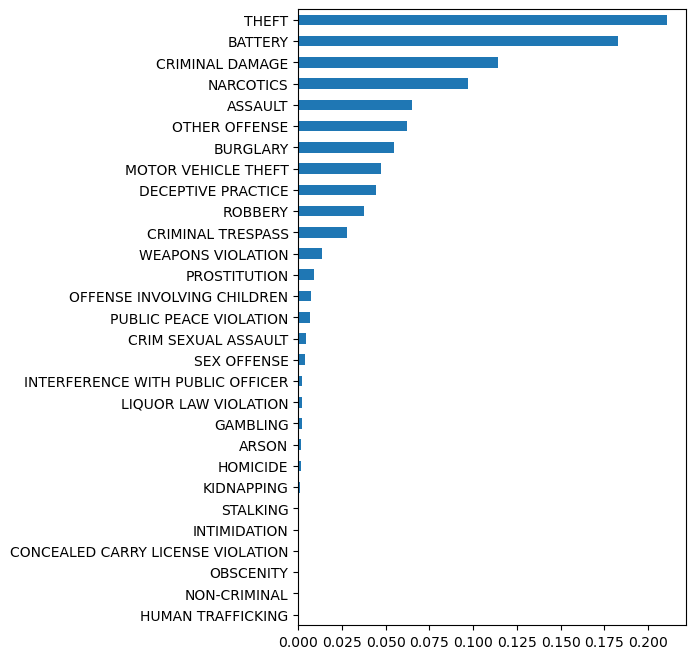

In [212]:
## Inspect the value_counts for the different types of crimes
crime_counts = chicago_final['Primary Type'].value_counts(normalize=True)
crime_counts.sort_values().plot(kind='barh',figsize=(5,8));

In [213]:
## Inspect the value_counts for the different types of crimes
crime_counts = chicago_final['Primary Type'].value_counts().to_frame('Total # of Crimes')
crime_counts

Total # of Crimes
THEFT                                        1626992
BATTERY                                      1410889
CRIMINAL DAMAGE                               878914
NARCOTICS                                     746302
ASSAULT                                       501103
OTHER OFFENSE                                 479392
BURGLARY                                      422246
MOTOR VEHICLE THEFT                           366586
DECEPTIVE PRACTICE                            340958
ROBBERY                                       289677
CRIMINAL TRESPASS                             212869
WEAPONS VIOLATION                             103906
PROSTITUTION                                   69750
OFFENSE INVOLVING CHILDREN                     55280
PUBLIC PEACE VIOLATION                         52086
CRIM SEXUAL ASSAULT                            33937
SEX OFFENSE                                    30442
INTERFERENCE WITH PUBLIC OFFICER               18206
LIQUOR LAW VIOLATION                           14846
GAMBLING                                       14616
ARSON                                          13121
HOMICIDE                                       12394
KIDNAPPING                                      7185
STALKING                                        4664
INTIMIDATION                                    4595
CONCEALED CARRY LICENSE VIOLATION               1019
OBSCENITY                                        810
NON-CRIMINAL                                     228
HUMAN TRAFFICKING                                 96

In [22]:
## Making a dictionary for crimes
CRIMES = {}

In [23]:
# 1. get list of  unique crime descriptions
crime_list = chicago_final['Primary Type'].unique()
crime_list

array(['BATTERY', 'THEFT', 'OTHER OFFENSE', 'MOTOR VEHICLE THEFT',
       'CRIM SEXUAL ASSAULT', 'SEX OFFENSE', 'ASSAULT', 'CRIMINAL DAMAGE',
       'BURGLARY', 'PUBLIC PEACE VIOLATION', 'OFFENSE INVOLVING CHILDREN',
       'GAMBLING', 'DECEPTIVE PRACTICE', 'NARCOTICS', 'WEAPONS VIOLATION',
       'LIQUOR LAW VIOLATION', 'ROBBERY', 'CRIMINAL TRESPASS',
       'INTERFERENCE WITH PUBLIC OFFICER', 'HOMICIDE', 'KIDNAPPING',
       'PROSTITUTION', 'STALKING', 'INTIMIDATION', 'ARSON', 'OBSCENITY',
       'CONCEALED CARRY LICENSE VIOLATION', 'NON-CRIMINAL',
       'HUMAN TRAFFICKING'], dtype=object)

In [24]:
# 2. Create an empty dictionary  
CRIMES = {}
# 3. Loop through the list of crimes
for crime in crime_list:
    # I. Save a temp df of just the rows that match the crime
   temp = chicago_final.loc[ chicago_final['Primary Type']==crime].copy()
    # II. Resample the temp DataFrame as Daily data (crime counts) 
    # and keep ONLY the .size() 
   temp_res = temp.resample("D").size() 
   #III. Save the temporary DataFrame in the dictionary,
   #using the crime description as the key.
   CRIMES[crime] = temp_res.copy() 
CRIMES.keys()

dict_keys(['BATTERY', 'THEFT', 'OTHER OFFENSE', 'MOTOR VEHICLE THEFT', 'CRIM SEXUAL ASSAULT', 'SEX OFFENSE', 'ASSAULT', 'CRIMINAL DAMAGE', 'BURGLARY', 'PUBLIC PEACE VIOLATION', 'OFFENSE INVOLVING CHILDREN', 'GAMBLING', 'DECEPTIVE PRACTICE', 'NARCOTICS', 'WEAPONS VIOLATION', 'LIQUOR LAW VIOLATION', 'ROBBERY', 'CRIMINAL TRESPASS', 'INTERFERENCE WITH PUBLIC OFFICER', 'HOMICIDE', 'KIDNAPPING', 'PROSTITUTION', 'STALKING', 'INTIMIDATION', 'ARSON', 'OBSCENITY', 'CONCEALED CARRY LICENSE VIOLATION', 'NON-CRIMINAL', 'HUMAN TRAFFICKING'])

In [25]:
crimes_df = pd.DataFrame(CRIMES)
crimes_df

BATTERY  THEFT  OTHER OFFENSE  MOTOR VEHICLE THEFT  \
Datetime                                                         
2001-01-01      296    412            167                   60   
2001-01-02      143    221            101                   65   
2001-01-03      165    226             96                   72   
2001-01-04      173    243             96                   87   
2001-01-05      178    265             90                   86   
...             ...    ...            ...                  ...   
2022-12-27       76    147             33                   77   
2022-12-28      102    112             38                  103   
2022-12-29       97    137             37                   95   
2022-12-30      106    125             38                   95   
2022-12-31      122    102             37                   88   

            CRIM SEXUAL ASSAULT  SEX OFFENSE  ASSAULT  CRIMINAL DAMAGE  \
Datetime                                                                 
2001-01-01                   41           65       70              233   
2001-01-02                    2            4       66              118   
2001-01-03                    7            5       79              136   
2001-01-04                    2            1       57              133   
2001-01-05                    6            2       68              142   
...                         ...          ...      ...              ...   
2022-12-27                    4            2       47               64   
2022-12-28                    4            0       44               78   
2022-12-29                    1            3       38               95   
2022-12-30                    4            0       51              100   
2022-12-31                    3            3       62              128   

            BURGLARY  PUBLIC PEACE VIOLATION  ...  HOMICIDE  KIDNAPPING  \
Datetime                                      ...                         
2001-01-01        66                       5  ...         2         2.0   
2001-01-02        68                       2  ...         0         1.0   
2001-01-03        57                       7  ...         0         3.0   
2001-01-04        55                       3  ...         2         2.0   
2001-01-05        55                       5  ...         1         3.0   
...              ...                     ...  ...       ...         ...   
2022-12-27        17                       1  ...         0         0.0   
2022-12-28        23                       1  ...         1         0.0   
2022-12-29        29                       2  ...         2         1.0   
2022-12-30        18                       2  ...         2         2.0   
2022-12-31        21                       1  ...         2         NaN   

            PROSTITUTION  STALKING  INTIMIDATION  ARSON  OBSCENITY  \
Datetime                                                             
2001-01-01           5.0         1           1.0    NaN        NaN   
2001-01-02          11.0         0           1.0    NaN        NaN   
2001-01-03          16.0         1           0.0    1.0        NaN   
2001-01-04          19.0         0           1.0    1.0        NaN   
2001-01-05          16.0         0           0.0    3.0        NaN   
...                  ...       ...           ...    ...        ...   
2022-12-27           NaN         1           0.0    0.0        NaN   
2022-12-28           NaN         1           0.0    0.0        NaN   
2022-12-29           NaN         1           1.0    0.0        NaN   
2022-12-30           NaN         2           2.0    0.0        NaN   
2022-12-31           NaN         1           NaN    3.0        NaN   

            CONCEALED CARRY LICENSE VIOLATION  NON-CRIMINAL  HUMAN TRAFFICKING  
Datetime                                                                        
2001-01-01                                NaN           NaN                NaN  
2001-01-02                                NaN           NaN 

# Analysis

##  1. Crimes Across the Years:

- Is the total number of crimes increasing or decreasing across the years?- Are there any individual crimes that are doing the opposite (e.g., decreasing when overall crime is increasing or vice-versa)?

In [26]:
## First, resample the data as annual 
full_year  = chicago_final.groupby('Primary Type').resample('A').sum()['Arrest'].reset_index()
full_year

Primary Type   Datetime  Arrest
0                ARSON 2001-12-31     181
1                ARSON 2002-12-31     156
2                ARSON 2003-12-31     140
3                ARSON 2004-12-31     109
4                ARSON 2005-12-31     121
..                 ...        ...     ...
622  WEAPONS VIOLATION 2018-12-31    3803
623  WEAPONS VIOLATION 2019-12-31    4223
624  WEAPONS VIOLATION 2020-12-31    5448
625  WEAPONS VIOLATION 2021-12-31    5560
626  WEAPONS VIOLATION 2022-12-31    5391

[627 rows x 3 columns]

In [27]:
## can pivot the result to have the datetime as the index and the crime as the columns
years_ts = full_year.pivot(index='Datetime',columns='Primary Type')
years_ts.head()

Arrest                            \
Primary Type  ARSON ASSAULT  BATTERY BURGLARY   
Datetime                                        
2001-12-31    181.0  7150.0  20464.0   1694.0   
2002-12-31    156.0  7341.0  21330.0   1667.0   
2003-12-31    140.0  6910.0  20460.0   1611.0   
2004-12-31    109.0  7005.0  20718.0   1378.0   
2005-12-31    121.0  6631.0  19994.0   1413.0   

                                                                    \
Primary Type CONCEALED CARRY LICENSE VIOLATION CRIM SEXUAL ASSAULT   
Datetime                                                             
2001-12-31                                 1.0               422.0   
2002-12-31                                 0.0               406.0   
2003-12-31                                 0.0               313.0   
2004-12-31                                 0.0               323.0   
2005-12-31                                 0.0               286.0   

                                                                            \
Primary Type CRIMINAL DAMAGE CRIMINAL TRESPASS DECEPTIVE PRACTICE GAMBLING   
Datetime                                                                     
2001-12-31            4548.0           10262.0             4789.0    931.0   
2002-12-31            4403.0           10632.0             3805.0    969.0   
2003-12-31            4060.0           11618.0             3549.0   1088.0   
2004-12-31            3965.0           12845.0             3292.0   1120.0   
2005-12-31            4083.0           13710.0             3203.0   1077.0   

              ...                                                     \
Primary Type  ... OBSCENITY OFFENSE INVOLVING CHILDREN OTHER OFFENSE   
Datetime      ...                                                      
2001-12-31    ...      19.0                      811.0        5310.0   
2002-12-31    ...      24.0                      777.0        5710.0   
2003-12-31    ...      15.0                      864.0        5862.0   
2004-12-31    ...      12.0                      699.0        5395.0   
2005-12-31    ...      17.0                      667.0        4730.0   

                                                                               \
Primary Type PROSTITUTION PUBLIC PEACE VIOLATION ROBBERY SEX OFFENSE STALKING   
Datetime                                                                        
2001-12-31         6023.0                  923.0  1840.0       841.0     51.0   
2002-12-31         6408.0                  929.0  1758.0       775.0     44.0   
2003-12-31         6214.0                 1049.0  1592.0       687.0     44.0   
2004-12-31         7474.0                 1307.0  1479.0       650.0     36.0   
2005-12-31         6116.0                 1583.0  1641.0       599.0     23.0   

                                         
Primary Type    THEFT WEAPONS VIOLATION  
Datetime                                 
2001-12-31    15546.0            3539.0  
2002-12-31    13697.0            3538.0  
2003-12-31    12889.0            3447.0  
2004-12-31    12068.0            3405.0  
2005-12-31    11338.0            3291.0  

[5 rows x 29 columns]

In [28]:
years_ts.columns = years_ts.columns.droplevel(0)
years_ts.columns

Index(['ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY',
       'CONCEALED CARRY LICENSE VIOLATION', 'CRIM SEXUAL ASSAULT',
       'CRIMINAL DAMAGE', 'CRIMINAL TRESPASS', 'DECEPTIVE PRACTICE',
       'GAMBLING', 'HOMICIDE', 'HUMAN TRAFFICKING',
       'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION', 'KIDNAPPING',
       'LIQUOR LAW VIOLATION', 'MOTOR VEHICLE THEFT', 'NARCOTICS',
       'NON-CRIMINAL', 'OBSCENITY', 'OFFENSE INVOLVING CHILDREN',
       'OTHER OFFENSE', 'PROSTITUTION', 'PUBLIC PEACE VIOLATION', 'ROBBERY',
       'SEX OFFENSE', 'STALKING', 'THEFT', 'WEAPONS VIOLATION'],
      dtype='object', name='Primary Type')

In [29]:
### Substract to get delta crmes
delta_crime_yrs = years_ts.loc['2022-12-31'] - years_ts.loc['2001-12-31']
delta_crime_yrs

Primary Type
ARSON                                 -146.0
ASSAULT                              -5146.0
BATTERY                             -14561.0
BURGLARY                             -1342.0
CONCEALED CARRY LICENSE VIOLATION      169.0
CRIM SEXUAL ASSAULT                   -365.0
CRIMINAL DAMAGE                      -3656.0
CRIMINAL TRESPASS                    -9017.0
DECEPTIVE PRACTICE                   -4524.0
GAMBLING                              -923.0
HOMICIDE                              -168.0
HUMAN TRAFFICKING                        NaN
INTERFERENCE WITH PUBLIC OFFICER        16.0
INTIMIDATION                           -73.0
KIDNAPPING                            -128.0
LIQUOR LAW VIOLATION                 -1436.0
MOTOR VEHICLE THEFT                  -2840.0
NARCOTICS                           -46037.0
NON-CRIMINAL                             NaN
OBSCENITY                               11.0
OFFENSE INVOLVING CHILDREN            -672.0
OTHER OFFENSE                        -3219

- There are plenty of columns that can and will be dropped later to make assessment easier

In [30]:
delta_crime_yrs.info()

<class 'pandas.core.series.Series'>
Index: 29 entries, ARSON to WEAPONS VIOLATION
Series name: None
Non-Null Count  Dtype  
--------------  -----  
27 non-null     float64
dtypes: float64(1)
memory usage: 1.5+ KB


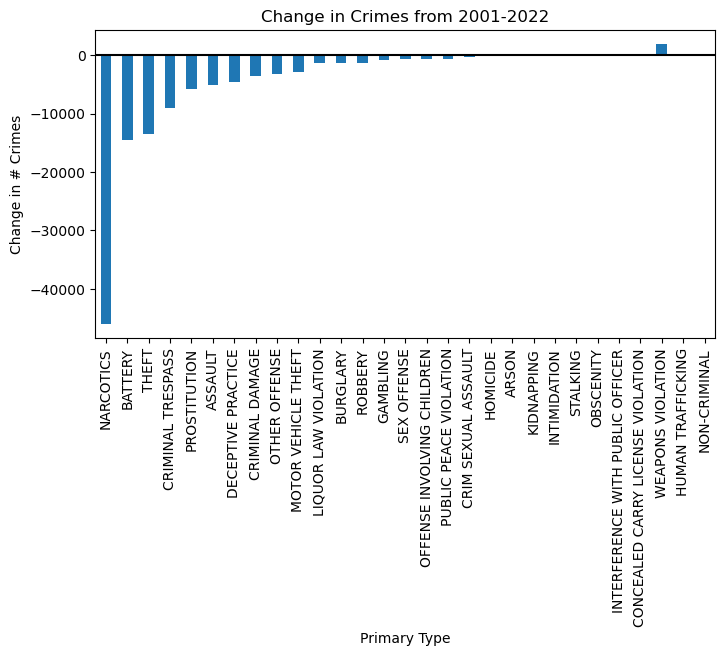

In [31]:
# Plotting the change in crimes from 2001 - 2022
ax = delta_crime_yrs.sort_values().plot(kind='bar',figsize=(8,4),
                                       ylabel='Change in # Crimes',
                                       title='Change in Crimes from 2001-2022')
ax.axhline(0,color='k');

- Most crimes have seen a large reduction in the past 22 years.
- Namely, There are far far fewer narcotics arrests made.
- There are a few crimes have seen more arrests, but most of them saw a increases in the douple or triple digits.
    - The one exception is weapons violation which saw a significant increase.

In [32]:
### Substract to get delta crmes
delta_crime_yrs2 = years_ts.loc['2022-12-31'] - years_ts.loc['2015-12-31']
delta_crime_yrs2

Primary Type
ARSON                                  -17.0
ASSAULT                              -2053.0
BATTERY                              -5660.0
BURGLARY                              -375.0
CONCEALED CARRY LICENSE VIOLATION      137.0
CRIM SEXUAL ASSAULT                   -121.0
CRIMINAL DAMAGE                       -943.0
CRIMINAL TRESPASS                    -3151.0
DECEPTIVE PRACTICE                    -754.0
GAMBLING                              -302.0
HOMICIDE                                46.0
HUMAN TRAFFICKING                       -4.0
INTERFERENCE WITH PUBLIC OFFICER      -909.0
INTIMIDATION                           -19.0
KIDNAPPING                              -5.0
LIQUOR LAW VIOLATION                   -91.0
MOTOR VEHICLE THEFT                   -425.0
NARCOTICS                           -19405.0
NON-CRIMINAL                            -5.0
OBSCENITY                               -6.0
OFFENSE INVOLVING CHILDREN            -291.0
OTHER OFFENSE                        -2719

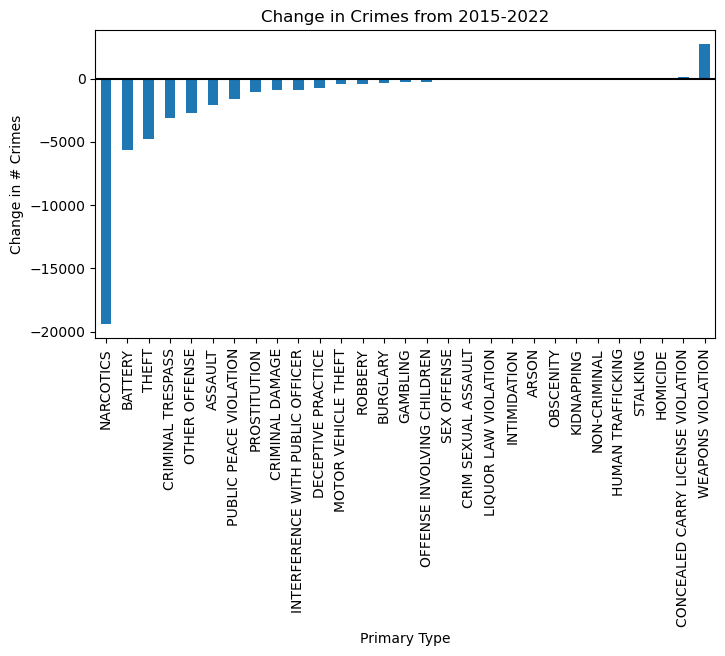

In [33]:
# Plotting the change in crimes from 2015-2022
ax = delta_crime_yrs2.sort_values().plot(kind='bar',figsize=(8,4),
                                       ylabel='Change in # Crimes',
                                       title='Change in Crimes from 2015-2022')
ax.axhline(0,color='k');

- In more recent years we see much of the same.
- Much fewer narcotics arrests, and much more weapons violations.

## 2. Comparing Police Districts
- Which district had the most crimes in 2022?
- Which had the least?

In [34]:
## First, resample the data as annual 
district_year  = chicago_final.groupby('District').resample('A').sum()['Arrest'].reset_index()
district_year

District   Datetime  Arrest
0         1.0 2001-12-31    4420
1         1.0 2002-12-31    6226
2         1.0 2003-12-31    6603
3         1.0 2004-12-31    6501
4         1.0 2005-12-31    7224
..        ...        ...     ...
502      31.0 2018-12-31       1
503      31.0 2019-12-31       1
504      31.0 2020-12-31       1
505      31.0 2021-12-31       4
506      31.0 2022-12-31       9

[507 rows x 3 columns]

In [35]:
## can pivot the result to have the datetime as the index and the crime as the columns
district_ts = district_year.pivot(index='Datetime',columns='District')
district_ts

Arrest                                                           \
District      1.0      2.0     3.0     4.0     5.0     6.0     7.0     8.0    
Datetime                                                                      
2001-12-31  4420.0  13344.0  6313.0  5748.0  4995.0  6720.0  6664.0  7645.0   
2002-12-31  6226.0   9232.0  6275.0  5531.0  5481.0  6412.0  8046.0  7124.0   
2003-12-31  6603.0   8332.0  6541.0  5736.0  5071.0  6627.0  7971.0  7646.0   
2004-12-31  6501.0   7925.0  7452.0  6594.0  5768.0  7199.0  9708.0  7859.0   
2005-12-31  7224.0   6644.0  7659.0  6110.0  5456.0  6607.0  8476.0  8020.0   
2006-12-31  6411.0   5711.0  7217.0  6254.0  5387.0  6559.0  8302.0  8391.0   
2007-12-31  5316.0   6095.0  7193.0  6175.0  5586.0  8279.0  7915.0  8212.0   
2008-12-31  3607.0   4811.0  6213.0  5906.0  4538.0  7390.0  7256.0  6613.0   
2009-12-31  4370.0   4635.0  5777.0  6151.0  4557.0  6603.0  6564.0  7289.0   
2010-12-31  3041.0   4008.0  5487.0  4792.0  4247.0  6150.0  6291.0  6902.0   
2011-12-31  3520.0   3885.0  4783.0  4912.0  4262.0  6003.0  6193.0  6850.0   
2012-12-31  3330.0   3155.0  4894.0  4432.0  4354.0  5816.0  6327.0  6051.0   
2013-12-31  3468.0   3404.0  4308.0  4220.0  4085.0  5395.0  5491.0  5081.0   
2014-12-31  3260.0   2709.0  3967.0  4794.0  3882.0  4715.0  4976.0  4713.0   
2015-12-31  2803.0   1939.0  3046.0  4322.0  3085.0  4472.0  5549.0  4112.0   
2016-12-31  2547.0   1703.0  2362.0  2836.0  2701.0  3447.0  3654.0  2948.0   
2017-12-31  2469.0   1764.0  2335.0  2976.0  2968.0  3774.0  3542.0  2698.0   
2018-12-31  2370.0   1751.0  2347.0  3139.0  3067.0  4134.0  3623.0  2595.0   
2019-12-31  2539.0   1924.0  2315.0  3602.0  2912.0  4266.0  3569.0  2691.0   
2020-12-31  1586.0   1048.0  1419.0  1875.0  1662.0  2670.0  2381.0  1595.0   
2021-12-31  1287.0    772.0  1079.0  1140.0  1229.0  1807.0  1545.0  1278.0   
2022-12-31  1647.0   1049.0  1087.0  1299.0  1260.0  1584.0  1222.0  1389.0   

                            ...                                               \
District      9.0     10.0  ...    16.0    17.0    18.0    19.0    20.0 21.0   
Datetime                    ...                                                
2001-12-31  7479.0  6300.0  ...  3531.0  3528.0  6954.0  6728.0  3062.0  NaN   
2002-12-31  7699.0  6206.0  ...  3334.0  3606.0  6710.0  6714.0  2729.0  NaN   
2003-12-31  7959.0  6187.0  ...  3332.0  3357.0  5875.0  6158.0  2391.0  0.0   
2004-12-31  7337.0  7600.0  ...  3432.0  3241.0  6298.0  5451.0  2240.0  2.0   
2005-12-31  6973.0  6978.0  ...  3114.0  3625.0  6423.0  5627.0  2539.0  NaN   
2006-12-31  7547.0  6770.0  ...  2802.0  3493.0  5765.0  4744.0  2247.0  NaN   
2007-12-31  7459.0  6508.0  ...  2705.0  3044.0  5082.0  4916.0  1953.0  NaN   
2008-12-31  5713.0  5753.0  ...  2540.0  2792.0  2836.0  2567.0  1115.0  NaN   
2009-12-31  6460.0  5096.0  ...  2481.0  2596.0  4095.0  3547.0  1432.0  NaN   
2010-12-31  5391.0  5195.0  ...  2379.0  2704.0  3356.0  2959.0  1342.0  NaN   
2011-12-31  5437.0  4534.0  ...  1972.0  2430.0  3712.0  3307.0  1493.0  NaN   
2012-12-31  4569.0  4727.0  ...  1954.0  1959.0  3202.0  3266.0  1353.0  NaN   
2013-12-31  4322.0  4932.0  ...  2187.0  1578.0  3007.0  2937.0  1130.0  NaN   
2014-12-31  3769.0  4260.0  ...  2041.0  1480.0  2526.0  2653.0  1109.0  NaN   
2015-12-31  3468.0  3619.0  ...  1872.0  1239.0  2247.0  2133.0   959.0  NaN   
2016-12-31  2592.0  2951.0  ...  1453.0  1078.0  1922.0  1821.0   729.0  NaN   
2017-12-31  2438.0  3588.0  ...  1463.0   905.0  2346.0  1634.0   772.0  NaN   
2018-12-31  2162.0  4082.0  ...  1198.0   833.0  2351.0  1622.0   740.0  NaN   
2019-12-31  2348.0  4168.0  ...  1258.0   841.0  2386.0  1603.0   612.0  NaN   
2020-12-31  1577.0  2362.0  ...  1015.0   598.0  1214.0   986.0   323.0  NaN   
2021-12-31  1088.0  1510.0  ...   992.0   451.0  1156.0   802.0   342.0  NaN   
2022-12-31  1126.0  1688.0  ...  1247.0   750.0  1457.0   921.0   451.0  NaN   

                                   

In [36]:
district_ts.columns = district_ts.columns.droplevel(0)
district_ts.columns

Float64Index([ 1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0, 11.0,
              12.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 24.0,
              25.0, 31.0],
             dtype='float64', name='District')

In [37]:
district_ts.loc['2022-12-31']

District
1.0     1647.0
2.0     1049.0
3.0     1087.0
4.0     1299.0
5.0     1260.0
6.0     1584.0
7.0     1222.0
8.0     1389.0
9.0     1126.0
10.0    1688.0
11.0    3097.0
12.0    1174.0
14.0     836.0
15.0    1277.0
16.0    1247.0
17.0     750.0
18.0    1457.0
19.0     921.0
20.0     451.0
21.0       NaN
22.0     769.0
24.0     844.0
25.0    1547.0
31.0       9.0
Name: 2022-12-31 00:00:00, dtype: float64

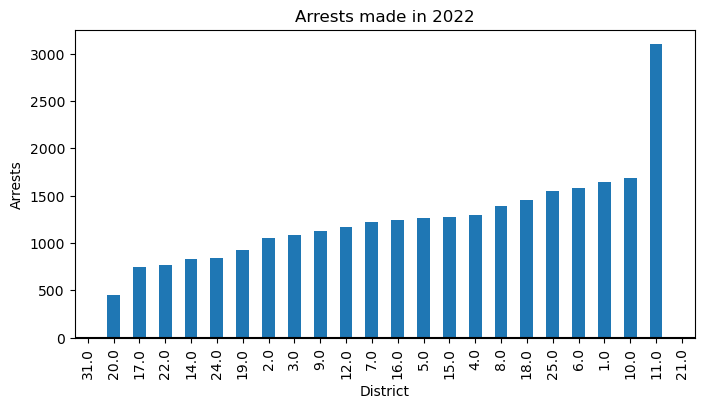

In [38]:
# Plotting the distribution of arrests in 2022
ax = district_ts.loc['2022-12-31'].sort_values().plot(kind='bar',figsize=(8,4),
                                       ylabel='Arrests',
                                       title='Arrests made in 2022')
ax.axhline(0,color='k');

- District 11 had much more arrests than any other district.
- District 31 had by far the fewest with only 9 arrests made.
- District 21 had no data, which either means there were no crimes, or they weren't recorded.

## 3. Comparing Months:
- Answer the question: ​What months have the most crime? What months have the least?
- Answer the question: Are there any individual crimes that do not follow this pattern? If so, which crimes?

#### All crimes by month

In [39]:
## Extracting the Month
chicago_final['Month'] = chicago_final.index.month
chicago_final['MonthName'] = chicago_final.index.month_name()
chicago_final.head(3)

Date Primary Type     Description  \
Datetime                                                                   
2001-01-01 01:00:00  01/01/2001 01:00:00 AM      BATTERY          SIMPLE   
2001-01-01 01:00:00  01/01/2001 01:00:00 AM      BATTERY          SIMPLE   
2001-01-01 01:00:00  01/01/2001 01:00:00 AM        THEFT  $500 AND UNDER   

                    Location Description  Arrest  Domestic  District  Month  \
Datetime                                                                      
2001-01-01 01:00:00            RESIDENCE   False     False      16.0      1   
2001-01-01 01:00:00            RESIDENCE   False     False       3.0      1   
2001-01-01 01:00:00  TAVERN/LIQUOR STORE   False     False       3.0      1   

                    MonthName  
Datetime                       
2001-01-01 01:00:00   January  
2001-01-01 01:00:00   January  
2001-01-01 01:00:00   January

In [40]:
# saving lookup for number vs name
unique_months = chicago_final.drop_duplicates(subset=['Month']).sort_values('Month')
month_lookup =dict(zip(unique_months['Month'],unique_months['MonthName']))
month_lookup

{1: 'January',
 2: 'February',
 3: 'March',
 4: 'April',
 5: 'May',
 6: 'June',
 7: 'July',
 8: 'August',
 9: 'September',
 10: 'October',
 11: 'November',
 12: 'December'}

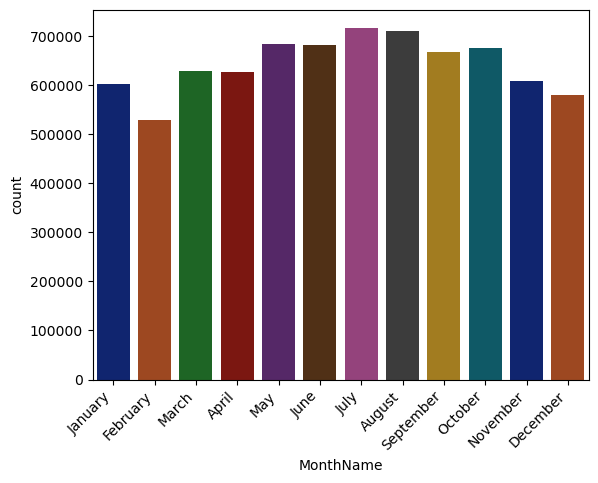

In [41]:
ax = sns.countplot(data=chicago_final, x='MonthName',palette='dark',order=month_lookup.values());
# Rotate xtick labels and align the text to the bar
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

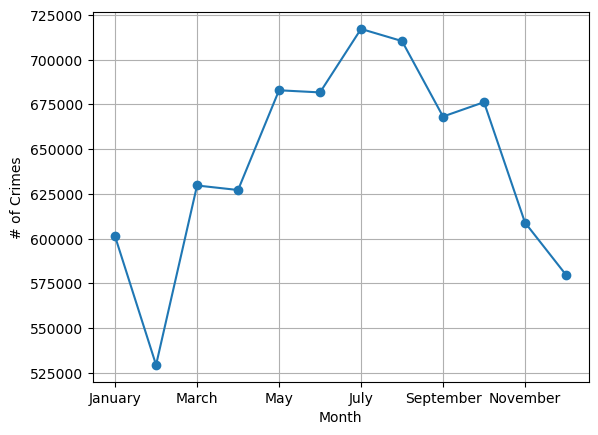

In [42]:
## save month counts
month_counts = chicago_final['MonthName'].value_counts()[month_lookup.values()]
# year_counts = df.groupby("Year").size()
ax = month_counts.plot(style='o-',grid=True,
                       ylabel='# of Crimes',
                       xlabel='Month');

- The warmer months have much higher reported crime rates, which makes sense if you consider that more people will be out and about.
- Colder months, especially February, have far fewer reported crimes. Understandable considering the cold Chicago 

#### Individual crimes per month

In [43]:
## Get # of crimes by Hour
crimes_by_month = chicago_final.groupby('Primary Type')['Month'].value_counts().sort_index()
crimes_by_month

Primary Type       Month
ARSON              1         917
                   2         807
                   3        1111
                   4        1097
                   5        1230
                            ... 
WEAPONS VIOLATION  8        9887
                   9        9435
                   10       9190
                   11       7952
                   12       7401
Name: Month, Length: 348, dtype: int64

In [44]:
## convert to dataframe and reset_index()
crimes_by_month_df = crimes_by_month.to_frame('# of Arrests').reset_index()
crimes_by_month_df

Primary Type  Month  # of Arrests
0                ARSON      1           917
1                ARSON      2           807
2                ARSON      3          1111
3                ARSON      4          1097
4                ARSON      5          1230
..                 ...    ...           ...
343  WEAPONS VIOLATION      8          9887
344  WEAPONS VIOLATION      9          9435
345  WEAPONS VIOLATION     10          9190
346  WEAPONS VIOLATION     11          7952
347  WEAPONS VIOLATION     12          7401

[348 rows x 3 columns]

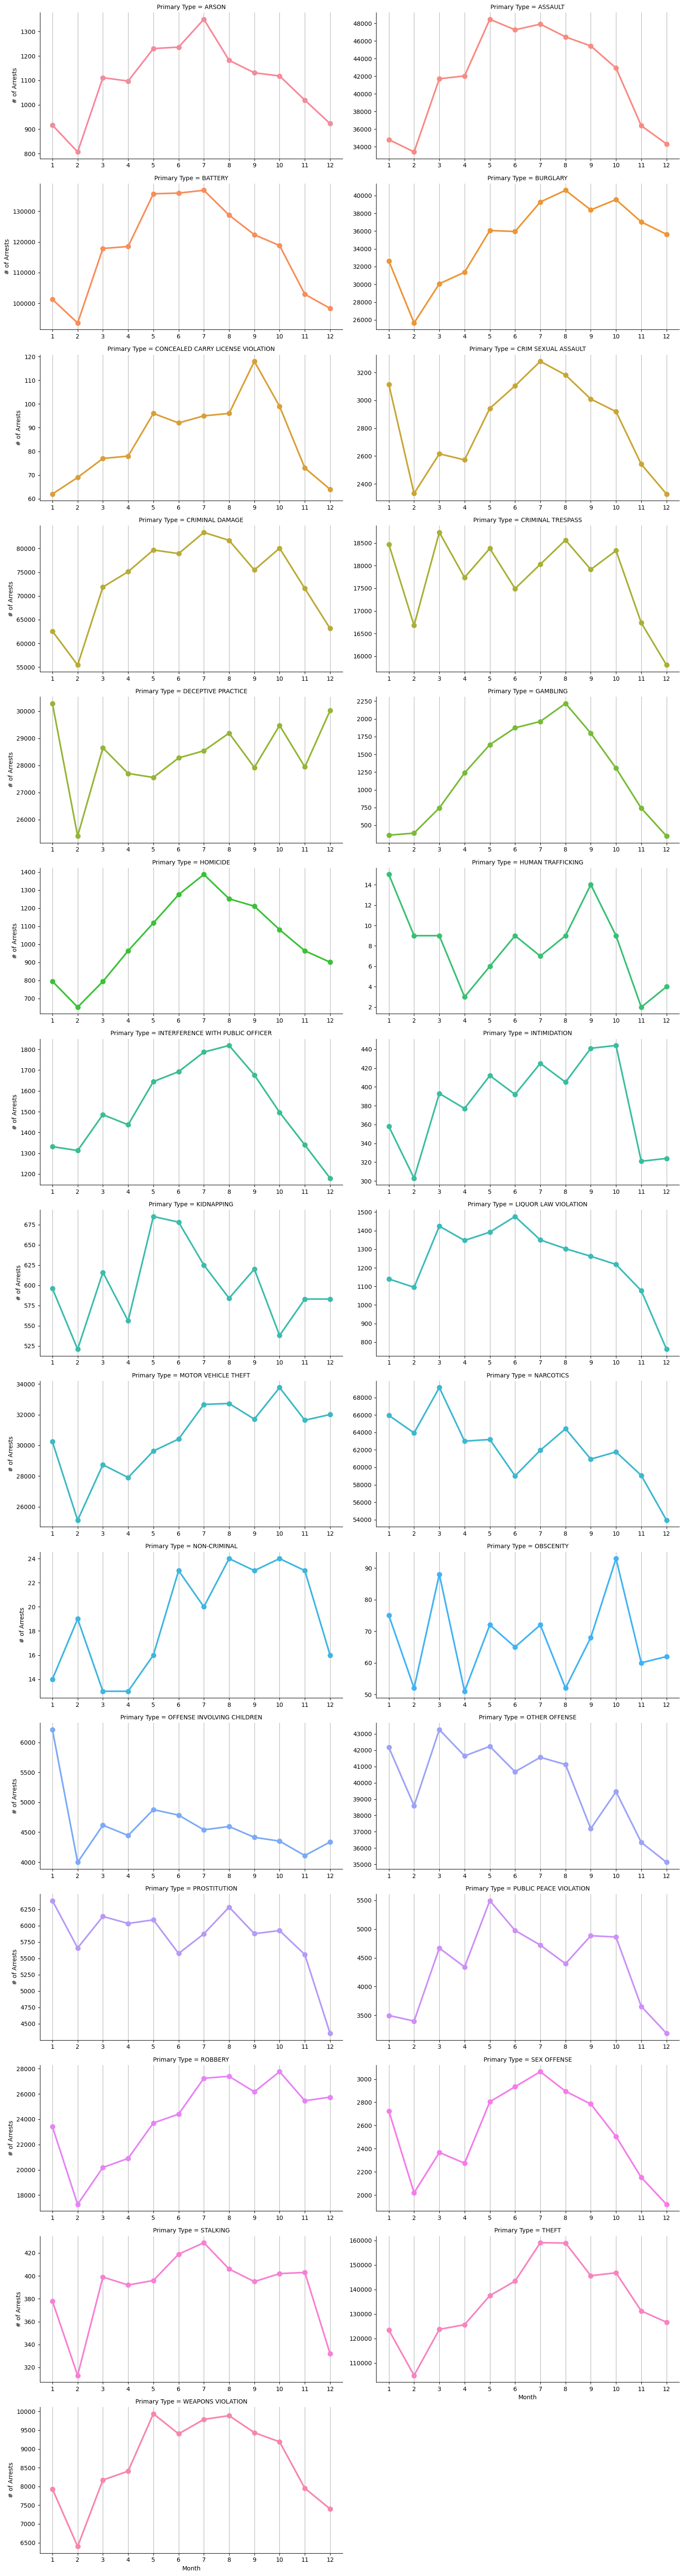

In [45]:
# Plotting arrests by month for each crime
g = sns.catplot(data= crimes_by_month_df, x = 'Month', y = '# of Arrests',
                kind='point',aspect=2, height=4,
                hue='Primary Type', col='Primary Type',col_wrap=2,
               sharey=False, sharex=False)
[ax.grid(axis='x') for ax in g.axes];

- Reported crimes being lower in the colder months (November through February) then seeing a sharp up-tick in the mid-year months seems fairly consistent accross all crimes.
    - Criminal Trespassing, Deceptive Practice, and Human Trafficking dont really seem to follow any kind of discernible pattern.
    - Understandably reported crimes with much lower frequency don't have enough entries to properly show pattern.

## Comparing Location Description

In [46]:
# Resampling as yearly 
full_year  = chicago_final.groupby('Location Description').resample('Y').sum()['Arrest'].reset_index()
full_year

Location Description   Datetime  Arrest
0    ABANDONED BUILDING/VACANT LOT 2001-12-31     782
1    ABANDONED BUILDING/VACANT LOT 2002-12-31     875
2    ABANDONED BUILDING/VACANT LOT 2003-12-31     829
3    ABANDONED BUILDING/VACANT LOT 2004-12-31     790
4    ABANDONED BUILDING/VACANT LOT 2005-12-31     748
..                             ...        ...     ...
885                      WAREHOUSE 2018-12-31      36
886                      WAREHOUSE 2019-12-31      38
887                      WAREHOUSE 2020-12-31      29
888                      WAREHOUSE 2021-12-31      15
889                      WAREHOUSE 2022-12-31      21

[890 rows x 3 columns]

In [47]:
# Pivoting the results to have datetime as the index.
years_ts = full_year.pivot(index = 'Datetime', columns = 'Location Description')
years_ts.head()

Arrest                   \
Location Description ABANDONED BUILDING/VACANT LOT AIRPORT/AIRCRAFT   
Datetime                                                              
2001-12-31                                   782.0            772.0   
2002-12-31                                   875.0            595.0   
2003-12-31                                   829.0            553.0   
2004-12-31                                   790.0            532.0   
2005-12-31                                   748.0            530.0   

                                                         \
Location Description ALLEY/GROUNDS AUTO REPAIR BANK/ATM   
Datetime                                                  
2001-12-31                  4461.0        58.0    719.0   
2002-12-31                  4699.0        60.0    620.0   
2003-12-31                  4844.0        47.0    582.0   
2004-12-31                  5102.0        23.0    487.0   
2005-12-31                  4903.0        26.0    582.0   

                                                                        \
Location Description BARBER SHOP/BEAUTY SALON BOAT/WATERCRAFT BUS STOP   
Datetime                                                                 
2001-12-31                               70.0             7.0      NaN   
2002-12-31                               50.0             7.0      NaN   
2003-12-31                               64.0            11.0      NaN   
2004-12-31                               82.0             3.0      NaN   
2005-12-31                               78.0             9.0      NaN   

                                                                         ...  \
Location Description CHURCH/SYNAGOGUE/PLACE OF WORSHIP COMMERCIAL STORE  ...   
Datetime                                                                 ...   
2001-12-31                                       135.0          14705.0  ...   
2002-12-31                                       117.0          13409.0  ...   
2003-12-31                                       144.0          13247.0  ...   
2004-12-31                                       142.0          13123.0  ...   
2005-12-31                                       135.0          12362.0  ...   

                                                                    \
Location Description RESTAURANT SCHOOL/COLLEGE/UNIVERSITY SIDEWALK   
Datetime                                                             
2001-12-31               1598.0                    3676.0  15139.0   
2002-12-31               1565.0                    4041.0  18203.0   
2003-12-31               1679.0                    4243.0  20061.0   
2004-12-31               1640.0                    4417.0  23697.0   
2005-12-31               1484.0                    4480.0  26040.0   

                                                                  \
Location Description SMALL VENDORS SPORTS ARENA/STADIUM   STREET   
Datetime                                                           
2001-12-31                    88.0                140.0  47266.0   
2002-12-31                    95.0                104.0  47018.0   
2003-12-31                    96.0                145.0  46959.0   
2004-12-31                    84.0                106.0  44537.0   
2005-12-31                    77.0                157.0  40219.0   

                                                                   
Location Description TAVERN/LIQUOR STORE  TRAIN VEHICLE WAREHOUSE  
Datetime                                                           
2001-12-31                        1610.0  223.0  1964.0     302.0  
2002-12-31                        1352.0  215.0  2223.0     266.0  
2003-12-31                        1315.0  247.0  2139.0     318.0  
2004-12-31                        1161.0  214.0  2485.0     197.0  
2005-12-31                        1195.0  250.0  2846.0     163.0  

[5 rows x 41 columns]

In [48]:
years_ts.columns = years_ts.columns.droplevel(0)
years_ts.columns

Index(['ABANDONED BUILDING/VACANT LOT', 'AIRPORT/AIRCRAFT', 'ALLEY/GROUNDS',
       'AUTO REPAIR', 'BANK/ATM', 'BARBER SHOP/BEAUTY SALON',
       'BOAT/WATERCRAFT', 'BUS STOP', 'CHURCH/SYNAGOGUE/PLACE OF WORSHIP',
       'COMMERCIAL STORE', 'CONSTRUCTION SITE',
       'FACTORY/MANUFACTURING BUILDING', 'FIRE STATION', 'GOVERNMENT BUILDING',
       'HALLWAY/STAIRWELL/ELEVATOR', 'HIGHWAY/EXPRESSWAY',
       'HOSPITAL/MEDICAL OFFICE', 'HOTEL/MOTEL', 'JAIL',
       'KENNEL/ANIMAL HOSPITAL', 'LAKEFRONT/WATERFRONT/RIVERBANK',
       'NURSING HOME/RETIREMENT HOME', 'NURSING/RETIREMENT HOME', 'OFFICE',
       'OTHER', 'PARK PROPERTY', 'PARKING LOT', 'POLICE FACILITY',
       'RAILROAD PROPERTY', 'RECREATION BUILDING', 'RESIDENCE', 'RESTAURANT',
       'SCHOOL/COLLEGE/UNIVERSITY', 'SIDEWALK', 'SMALL VENDORS',
       'SPORTS ARENA/STADIUM', 'STREET', 'TAVERN/LIQUOR STORE', 'TRAIN',
       'VEHICLE', 'WAREHOUSE'],
      dtype='object', name='Location Description')

In [49]:
### Substract to get delta crmes
delta_loc_yrs = years_ts.loc['2022-12-31'] - years_ts.loc['2001-12-31']
delta_loc_yrs

Location Description
ABANDONED BUILDING/VACANT LOT         -615.0
AIRPORT/AIRCRAFT                      -366.0
ALLEY/GROUNDS                        -3565.0
AUTO REPAIR                            -51.0
BANK/ATM                              -671.0
BARBER SHOP/BEAUTY SALON               -55.0
BOAT/WATERCRAFT                         -2.0
BUS STOP                                 NaN
CHURCH/SYNAGOGUE/PLACE OF WORSHIP     -101.0
COMMERCIAL STORE                    -11811.0
CONSTRUCTION SITE                     -136.0
FACTORY/MANUFACTURING BUILDING        -103.0
FIRE STATION                            -5.0
GOVERNMENT BUILDING                   -146.0
HALLWAY/STAIRWELL/ELEVATOR           -2205.0
HIGHWAY/EXPRESSWAY                     -21.0
HOSPITAL/MEDICAL OFFICE               -180.0
HOTEL/MOTEL                           -515.0
JAIL                                    12.0
KENNEL/ANIMAL HOSPITAL                   NaN
LAKEFRONT/WATERFRONT/RIVERBANK         -10.0
NURSING HOME/RETIREMENT HOME      

In [50]:
delta_loc_yrs.info()

<class 'pandas.core.series.Series'>
Index: 41 entries, ABANDONED BUILDING/VACANT LOT to WAREHOUSE
Series name: None
Non-Null Count  Dtype  
--------------  -----  
37 non-null     float64
dtypes: float64(1)
memory usage: 1.7+ KB


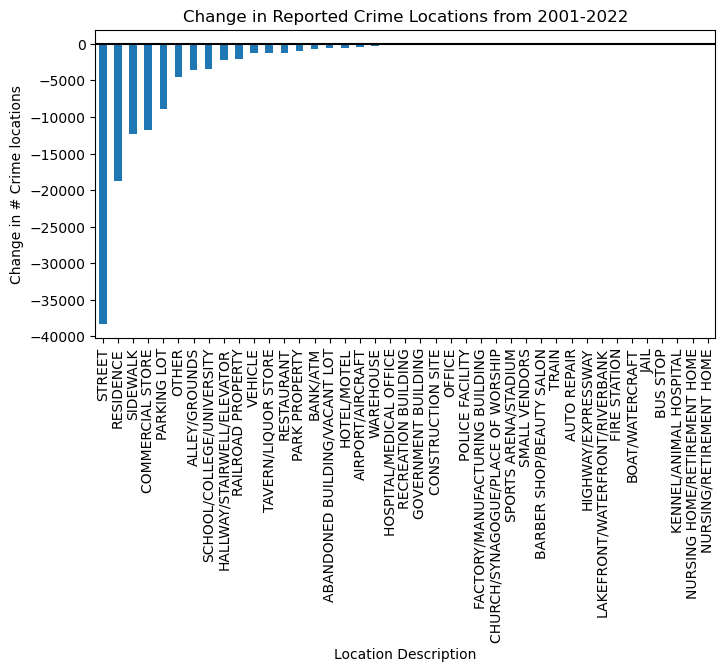

In [51]:
# Plotting the change in crimes from 2001 - 2022
ax = delta_loc_yrs.sort_values().plot(kind='bar',figsize=(8,4),
                                       ylabel='Change in # Crime locations',
                                       title='Change in Reported Crime Locations from 2001-2022')
ax.axhline(0,color='k');

## Analyzing via Crime Type

### Time Series Modeling

#### Resampling as months

In [52]:
## First, resample the data as monthly 
full_month  = chicago_final.groupby('Primary Type').resample('M').sum()['Arrest'].reset_index()
full_month

Primary Type   Datetime  Arrest
0                 ARSON 2001-01-31      14
1                 ARSON 2001-02-28       7
2                 ARSON 2001-03-31      17
3                 ARSON 2001-04-30      28
4                 ARSON 2001-05-31      19
...                 ...        ...     ...
7499  WEAPONS VIOLATION 2022-08-31     492
7500  WEAPONS VIOLATION 2022-09-30     490
7501  WEAPONS VIOLATION 2022-10-31     416
7502  WEAPONS VIOLATION 2022-11-30     317
7503  WEAPONS VIOLATION 2022-12-31     315

[7504 rows x 3 columns]

In [53]:
## can pivot the result to have the datetime as the index and the crime as the columns
months_ts = full_month.pivot(index='Datetime',columns='Primary Type')
months_ts.head()

Arrest                           \
Primary Type  ARSON ASSAULT BATTERY BURGLARY   
Datetime                                       
2001-01-31     14.0   515.0  1499.0    117.0   
2001-02-28      7.0   501.0  1433.0    107.0   
2001-03-31     17.0   631.0  1660.0    130.0   
2001-04-30     28.0   639.0  1845.0    129.0   
2001-05-31     19.0   638.0  1921.0    112.0   

                                                                    \
Primary Type CONCEALED CARRY LICENSE VIOLATION CRIM SEXUAL ASSAULT   
Datetime                                                             
2001-01-31                                 NaN                41.0   
2001-02-28                                 NaN                36.0   
2001-03-31                                 NaN                31.0   
2001-04-30                                 NaN                36.0   
2001-05-31                                 1.0                29.0   

                                                                            \
Primary Type CRIMINAL DAMAGE CRIMINAL TRESPASS DECEPTIVE PRACTICE GAMBLING   
Datetime                                                                     
2001-01-31             337.0            1014.0              467.0     43.0   
2001-02-28             333.0             838.0              410.0     37.0   
2001-03-31             372.0             877.0              471.0     55.0   
2001-04-30             448.0             894.0              405.0     79.0   
2001-05-31             390.0             830.0              455.0     94.0   

              ...                                                     \
Primary Type  ... OBSCENITY OFFENSE INVOLVING CHILDREN OTHER OFFENSE   
Datetime      ...                                                      
2001-01-31    ...       2.0                       79.0         362.0   
2001-02-28    ...       1.0                       61.0         385.0   
2001-03-31    ...       2.0                       82.0         439.0   
2001-04-30    ...       2.0                       67.0         403.0   
2001-05-31    ...       1.0                       61.0         516.0   

                                                                               \
Primary Type PROSTITUTION PUBLIC PEACE VIOLATION ROBBERY SEX OFFENSE STALKING   
Datetime                                                                        
2001-01-31          563.0                   45.0   197.0        70.0      8.0   
2001-02-28          425.0                   53.0   139.0        58.0      4.0   
2001-03-31          550.0                   91.0   142.0        70.0      3.0   
2001-04-30          564.0                   73.0   124.0        74.0      8.0   
2001-05-31          503.0                   73.0   160.0        90.0      6.0   

                                        
Primary Type   THEFT WEAPONS VIOLATION  
Datetime                                
2001-01-31    1426.0             275.0  
2001-02-28    1139.0             222.0  
2001-03-31    1283.0             240.0  
2001-04-30    1227.0             267.0  
2001-05-31    1290.0             314.0  

[5 rows x 29 columns]

In [54]:
months_ts.columns

MultiIndex([('Arrest',                             'ARSON'),
            ('Arrest',                           'ASSAULT'),
            ('Arrest',                           'BATTERY'),
            ('Arrest',                          'BURGLARY'),
            ('Arrest', 'CONCEALED CARRY LICENSE VIOLATION'),
            ('Arrest',               'CRIM SEXUAL ASSAULT'),
            ('Arrest',                   'CRIMINAL DAMAGE'),
            ('Arrest',                 'CRIMINAL TRESPASS'),
            ('Arrest',                'DECEPTIVE PRACTICE'),
            ('Arrest',                          'GAMBLING'),
            ('Arrest',                          'HOMICIDE'),
            ('Arrest',                 'HUMAN TRAFFICKING'),
            ('Arrest',  'INTERFERENCE WITH PUBLIC OFFICER'),
            ('Arrest',                      'INTIMIDATION'),
            ('Arrest',                        'KIDNAPPING'),
            ('Arrest',              'LIQUOR LAW VIOLATION'),
            ('Arrest',  

### Narcotics

#### data prep

In [55]:
nar_ts = months_ts['Arrest']
nar_ts = nar_ts['NARCOTICS']
nar_ts

Datetime
2001-01-31    4715.0
2001-02-28    4369.0
2001-03-31    4861.0
2001-04-30    4043.0
2001-05-31    4040.0
               ...  
2022-08-31     410.0
2022-09-30     371.0
2022-10-31     341.0
2022-11-30     319.0
2022-12-31     310.0
Name: NARCOTICS, Length: 264, dtype: float64

- We are attemptign to forecast 6 months.
- So in order to make the data more significant I'll limit the data used to 2017 onwards.

In [56]:
nar_ts = nar_ts.loc['2017':]
nar_ts

Datetime
2017-01-31     984.0
2017-02-28     956.0
2017-03-31    1127.0
2017-04-30    1042.0
2017-05-31    1118.0
               ...  
2022-08-31     410.0
2022-09-30     371.0
2022-10-31     341.0
2022-11-30     319.0
2022-12-31     310.0
Name: NARCOTICS, Length: 72, dtype: float64

In [57]:
nar_ts.isna().sum()

0

#### Determining the correct model

<Axes: xlabel='Datetime'>

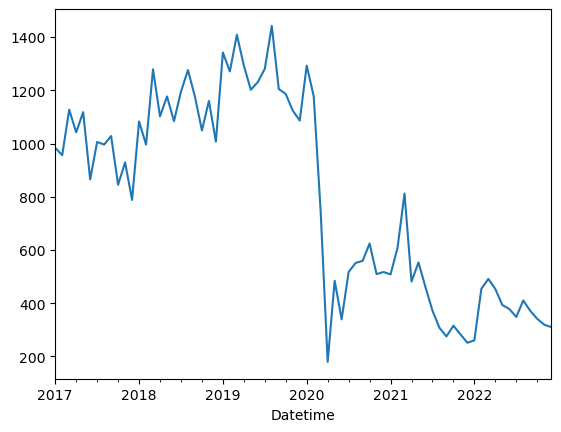

In [58]:
nar_ts.plot()

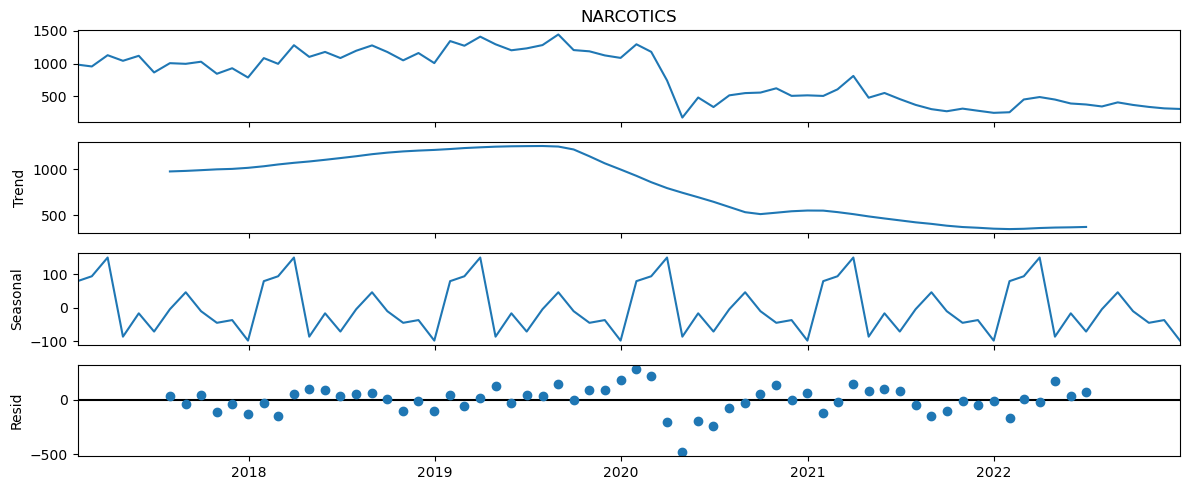

In [59]:
# We see a repeating pattern that is likely seasonal
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(nar_ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

- Seasonality seem likely, although there are many residuals.

In [60]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(nar_ts.max() - nar_ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 247.26666666666665 which is ~19.58% of the variation in time series.


- seasonality accoutnign for 10% seems to point towards seasonal trends.

In [61]:
# check for nonseasonal differencing
ndiffs(nar_ts)

1

In [62]:
nar_ts_diff = nar_ts.diff().dropna()

In [63]:
# Check for seasonal differcing
nsdiffs(nar_ts, m = 12)

0

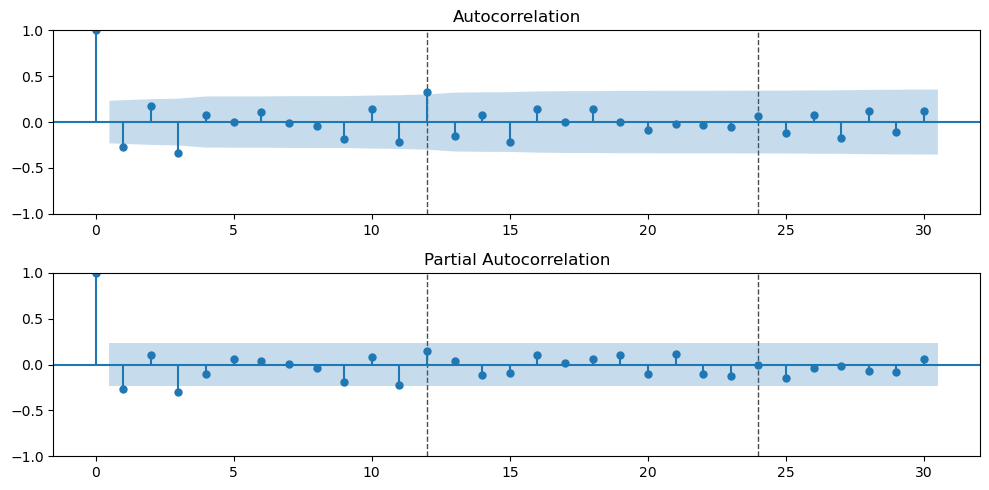

In [64]:
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(nar_ts_diff, annotate_seas=True, m = 12, nlags = 30);

- Both the ACF and the PACF taper off rather slowly, I'll start with 1,1.

#### Train Test Split

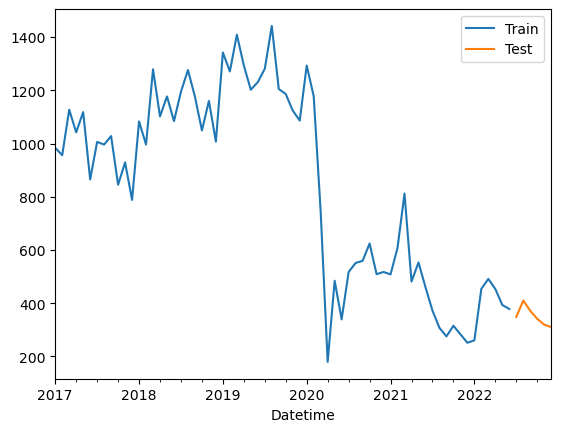

In [65]:
# tts so test size is 6 lags
test_lags = 6 
train, test = train_test_split(nar_ts, test_size= test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

#### Manual Model

In [66]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1 # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                        NARCOTICS   No. Observations:                   66
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -416.329
Date:                          Thu, 10 Apr 2025   AIC                            842.658
Time:                                  15:37:23   BIC                            853.530
Sample:                              01-31-2017   HQIC                           846.948
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9762      0.047    -20.564      0.000      -1.069      -0.883
ma.L1          0.9114      0.096      9.533      0.000       0.724       1.099
ar.S.L12       0.0774      1.035      0.075      0.940      -1.951       2.106
ma.S.L12       0.1964      1.072      0.183      0.855      -1.904       2.297
sigma2      2.099e+04   2913.387      7.205      0.000    1.53e+04    2.67e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                37.89
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.93
Prob(H) (two-sided):                  0.71   Kurtosis:                         6.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

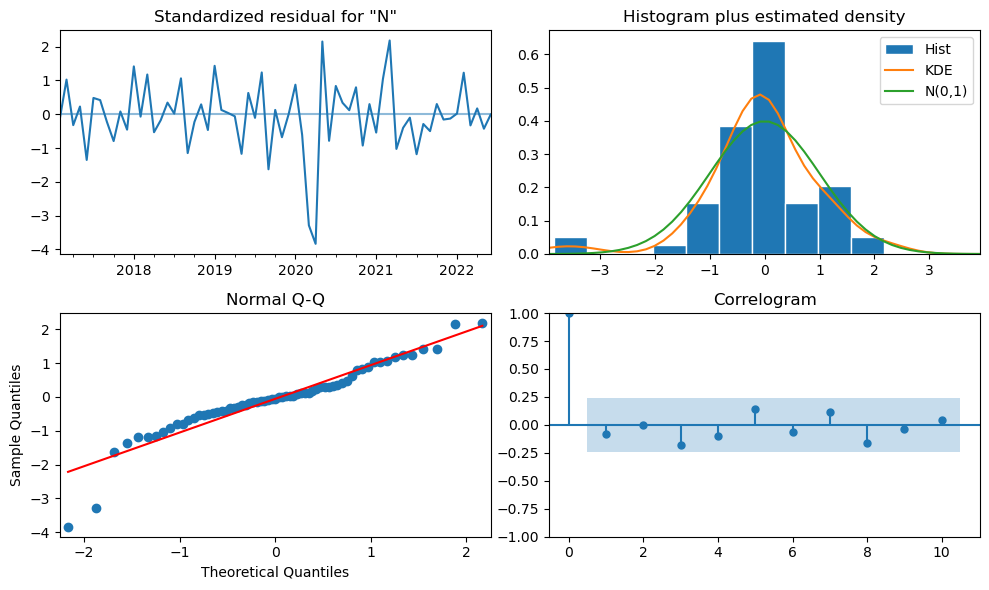

In [67]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 28.843
- MSE = 1,824.557
- RMSE = 42.715
- R^2 = -0.637
- MAPE = 7.54%


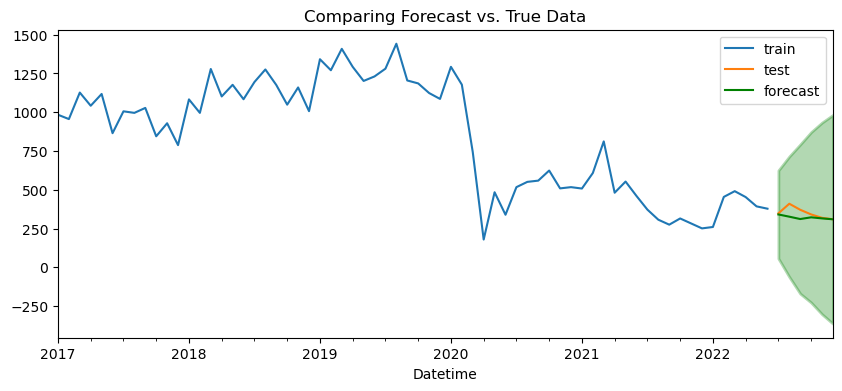

In [68]:
# Obtain forecast as a dataframe with confidence intervals
nar_forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, nar_forecast_df);
# Obtain metrics
regression_metrics_ts(test, nar_forecast_df['mean'])

- A Fairly high MAPE value of 7.44%, this could be for a few reasons.
    - Most likely because I'm not entirely sure how to pick the seasonal paramters.

#### Auto ARIMA optimization

In [69]:
import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=849.508, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=842.944, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=843.331, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=847.724, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=846.653, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=844.901, Time=0.22 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=844.874, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=842.984, Time=0.06 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=843.408, Time=0.05 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=844.200, Time=0.13 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=842.661, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=845.283, Time=0.06 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AI

In [70]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
print(auto_model.order)
print(auto_model.seasonal_order)

(1, 1, 1)
(0, 0, 1, 12)


In [71]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1 # nonseasonal MA

# Orders for seasonal components
P = 0 # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

auto_sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Or instead of manually defining the orders, you can obtain them programmatically
# auto_sarima = tsa.ARIMA(train, order = auto_model.order, seasonal_order = auto_model.seasonal_order)

# Obtain model summary
auto_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                        NARCOTICS   No. Observations:                   66
Model:             ARIMA(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -416.340
Date:                          Thu, 10 Apr 2025   AIC                            840.679
Time:                                  15:37:30   BIC                            849.377
Sample:                              01-31-2017   HQIC                           844.111
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9772      0.035    -27.669      0.000      -1.046      -0.908
ma.L1          0.9128      0.067     13.613      0.000       0.781       1.044
ma.S.L12       0.2701      0.111      2.435      0.015       0.053       0.488
sigma2        2.1e+04   2588.807      8.110      0.000    1.59e+04    2.61e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                37.26
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.92
Prob(H) (two-sided):                  0.72   Kurtosis:                         6.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

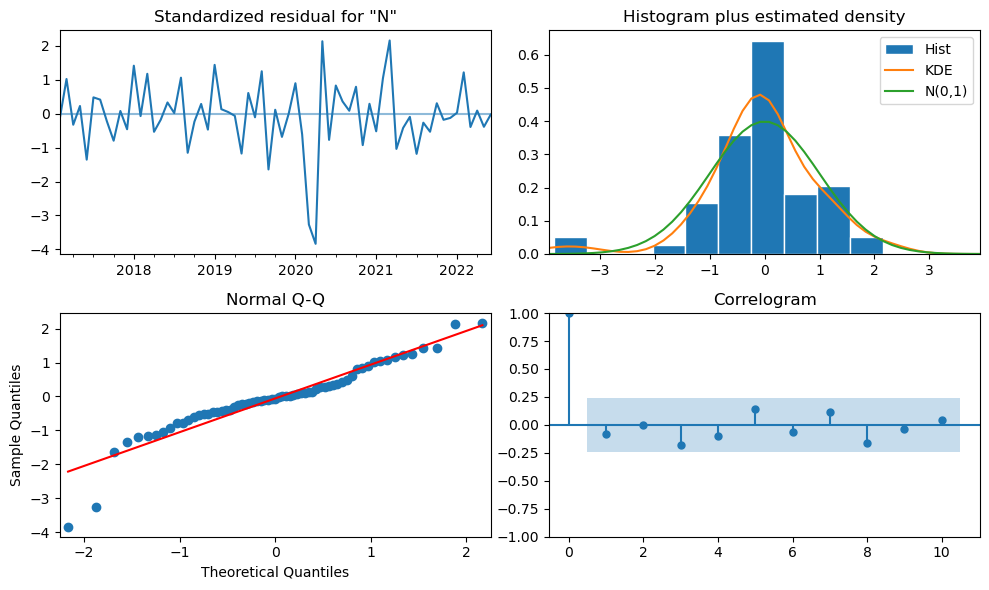

In [72]:
# Obtain diagnostic plots
fig = auto_sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 31.766
- MSE = 1,982.445
- RMSE = 44.525
- R^2 = -0.779
- MAPE = 8.40%


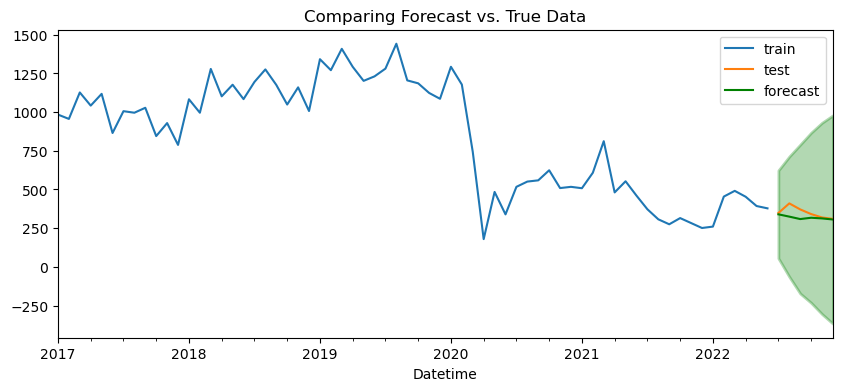

In [73]:
# Obtain summary of forecast as dataframe
nar_forecast_df = auto_sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, nar_forecast_df)
# Obtain metrics
regression_metrics_ts(test, nar_forecast_df["mean"])

- The auto ARIMA model has slightly more error than the manual model, so I'll stick with the manual model.

#### Choosing final model

In [74]:
# These are the parameters of our final model
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

nar_final_model = tsa.ARIMA(nar_ts, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

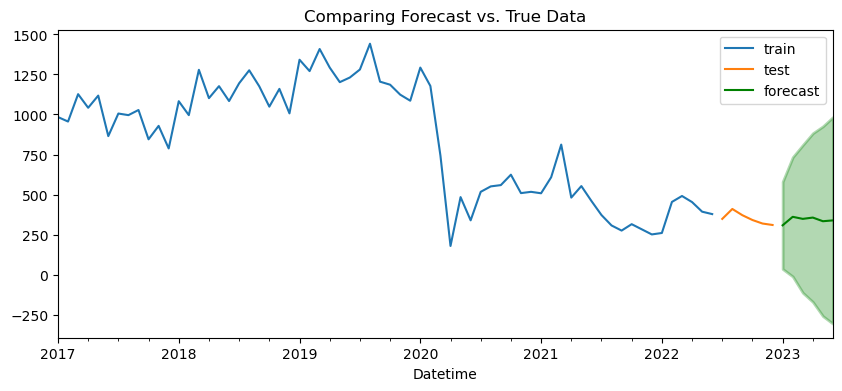

In [75]:
# Obtain future forecasts beyond test data
nar_forecast_df  = nar_final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,nar_forecast_df);

### Assault

#### Data prep

In [76]:
as_ts = months_ts['Arrest']
as_ts = as_ts['ASSAULT']
as_ts

Datetime
2001-01-31    515.0
2001-02-28    501.0
2001-03-31    631.0
2001-04-30    639.0
2001-05-31    638.0
              ...  
2022-08-31    208.0
2022-09-30    187.0
2022-10-31    158.0
2022-11-30    144.0
2022-12-31    149.0
Name: ASSAULT, Length: 264, dtype: float64

- We are attemptign to forecast 6 months.
- So in order to make the data more significant I'll limit the data used to 2017 onwards.

In [77]:
as_ts = as_ts.loc['2017':]
as_ts

Datetime
2017-01-31    234.0
2017-02-28    263.0
2017-03-31    272.0
2017-04-30    313.0
2017-05-31    328.0
              ...  
2022-08-31    208.0
2022-09-30    187.0
2022-10-31    158.0
2022-11-30    144.0
2022-12-31    149.0
Name: ASSAULT, Length: 72, dtype: float64

In [78]:
nar_ts.isna().sum()

0

#### Determining Model

<Axes: xlabel='Datetime'>

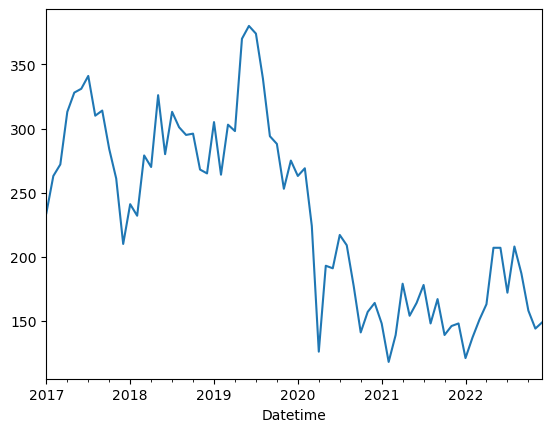

In [79]:
as_ts.plot()

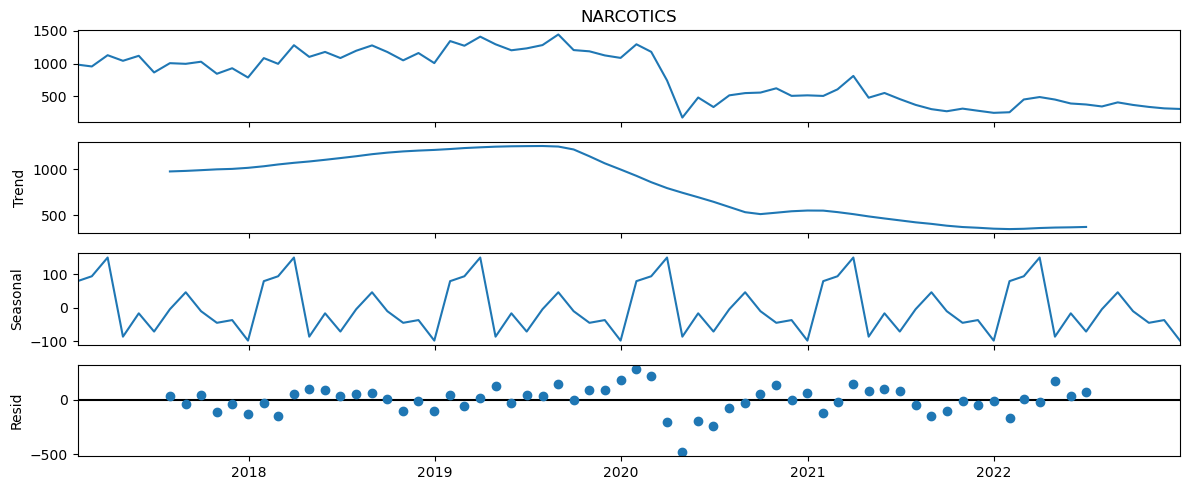

In [80]:
# We see a repeating pattern that is likely seasonal
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(nar_ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

- Seasonality is in question
- The trend lines are concerning, and the residuals are a but sporatice.
- I will continue with the idea that the data is seasonal.

In [81]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(as_ts.max() - as_ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 247.26666666666665 which is ~94.38% of the variation in time series.


- 94.3%?

In [82]:
# check for nonseasonal differencing
ndiffs(as_ts)

1

In [83]:
as_ts_diff = as_ts.diff().dropna()

In [84]:
# Check for seasonal differcing
nsdiffs(as_ts, m = 12)

0

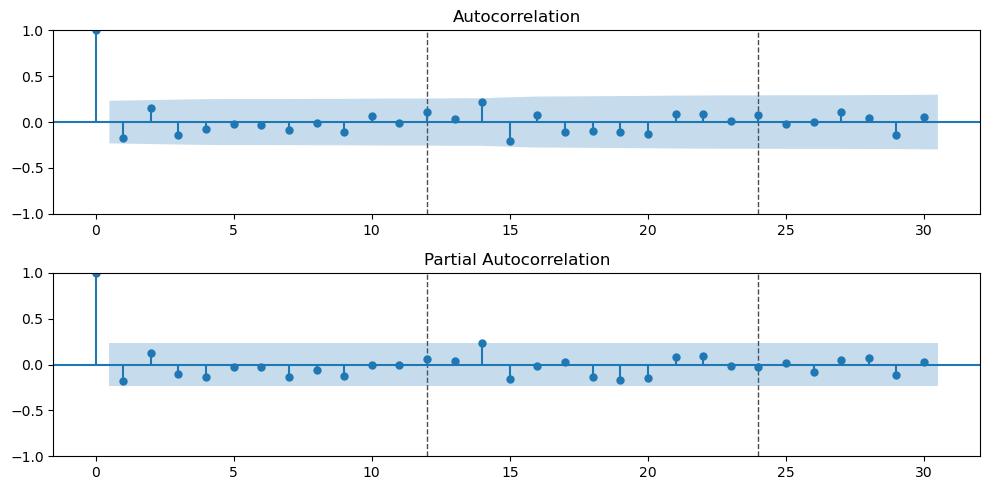

In [85]:
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(as_ts_diff, annotate_seas=True, m = 12, nlags = 30);

- Both the ACF and PACF have immediate dips, I'll start with 0,0

#### Train Test Split

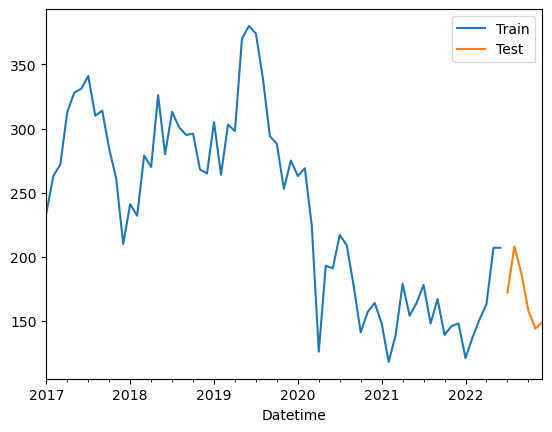

In [86]:
# tts so test size is 6 lags
test_lags = 6 
train, test = train_test_split(as_ts, test_size= test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [87]:
# Orders for non seasonal components
p = 0  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0 # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                          ASSAULT   No. Observations:                   66
Model:             ARIMA(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -314.978
Date:                          Thu, 10 Apr 2025   AIC                            633.957
Time:                                  15:37:33   BIC                            638.305
Sample:                              01-31-2017   HQIC                           635.673
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.1467      0.105      1.398      0.162      -0.059       0.352
sigma2       943.6726    158.030      5.971      0.000     633.939    1253.406
===================================================================================
Ljung-Box (L1) (Q):                   2.15   Jarque-Bera (JB):                 0.73
Prob(Q):                              0.14   Prob(JB):                         0.69
Heteroskedasticity (H):               0.78   Skew:                            -0.23
Prob(H) (two-sided):                  0.57   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

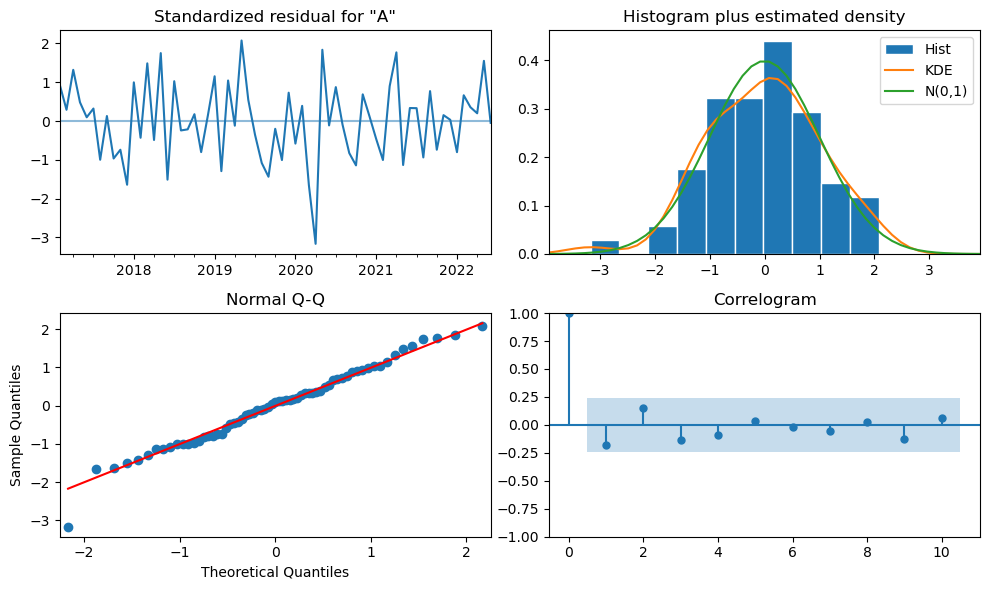

In [88]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 37.031
- MSE = 1,766.243
- RMSE = 42.027
- R^2 = -2.536
- MAPE = 23.67%


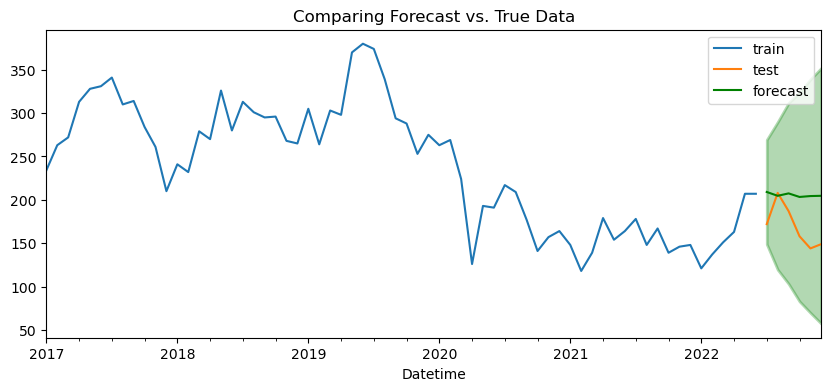

In [89]:
# Obtain forecast as a dataframe with confidence intervals
as_forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, as_forecast_df);
# Obtain metrics
regression_metrics_ts(test, as_forecast_df['mean'])

- This model is horrendous. Not sure which value is off.
- Possibly the model is not seasonal, but I'm not sure how to account for the pseudo-seasonal dips.

#### Auto ARIMA optimization

In [90]:
import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=635.296, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=635.918, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=636.506, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=633.308, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=635.953, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=636.136, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=635.373, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=635.831, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=636.217, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.882 seconds


In [91]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
print(auto_model.order)
print(auto_model.seasonal_order)

(0, 1, 0)
(0, 0, 0, 12)


- Best model found is not seasonal

In [92]:
# Orders for non seasonal components
p = 0 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0 # nonseasonal MA
auto_arima = tsa.ARIMA(train, order = (p,d,q)).fit()

# Or instead of manually defining the orders, you can obtain them programmatically
# auto_sarima = tsa.ARIMA(train, order = auto_model.order, seasonal_order = auto_model.seasonal_order)

# Obtain model summary
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                ASSAULT   No. Observations:                   66
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -315.654
Date:                Thu, 10 Apr 2025   AIC                            633.308
Time:                        15:37:35   BIC                            635.482
Sample:                    01-31-2017   HQIC                           634.166
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       967.3516    155.301      6.229      0.000     662.967    1271.736
===================================================================================
Ljung-Box (L1) (Q):                   1.99   Jarque-Bera (JB):                 0.60
Prob(Q):                              0.16   Prob(JB):                         0.74
Heteroskedasticity (H):               0.65   Skew:                            -0.14
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

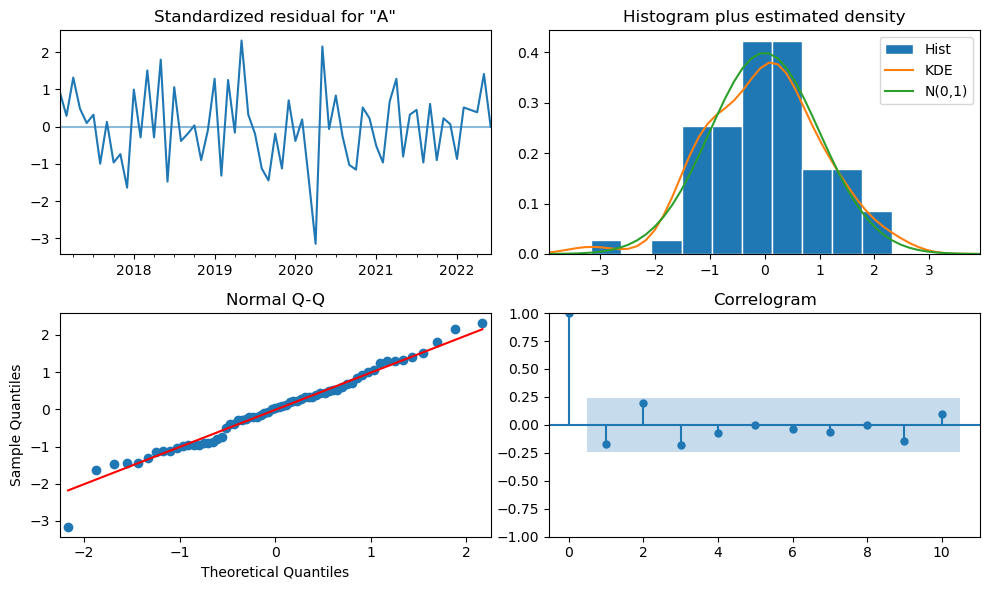

In [93]:
# Obtain diagnostic plots
fig = auto_arima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 37.667
- MSE = 1,893.333
- RMSE = 43.512
- R^2 = -2.790
- MAPE = 24.20%


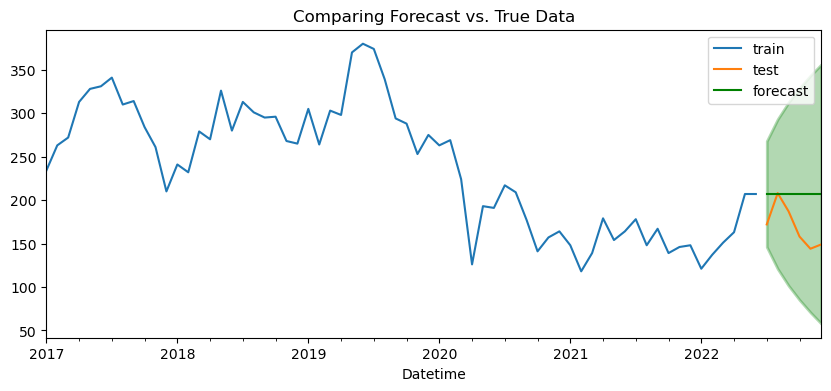

In [94]:
# Obtain summary of forecast as dataframe
forecast_df = auto_arima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

- It's even worse.

#### Guess and Check

In [95]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

guess_sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Or instead of manually defining the orders, you can obtain them programmatically
# auto_sarima = tsa.ARIMA(train, order = auto_model.order, seasonal_order = auto_model.seasonal_order)

# Obtain model summary
auto_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                        NARCOTICS   No. Observations:                   66
Model:             ARIMA(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -416.340
Date:                          Thu, 10 Apr 2025   AIC                            840.679
Time:                                  15:37:36   BIC                            849.377
Sample:                              01-31-2017   HQIC                           844.111
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9772      0.035    -27.669      0.000      -1.046      -0.908
ma.L1          0.9128      0.067     13.613      0.000       0.781       1.044
ma.S.L12       0.2701      0.111      2.435      0.015       0.053       0.488
sigma2        2.1e+04   2588.807      8.110      0.000    1.59e+04    2.61e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                37.26
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.92
Prob(H) (two-sided):                  0.72   Kurtosis:                         6.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

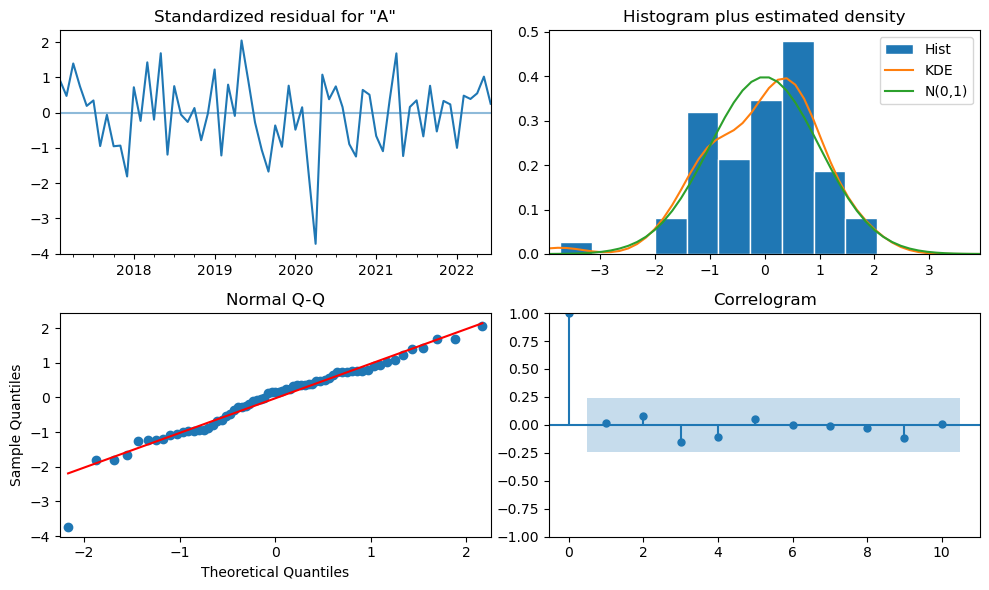

In [96]:
# Obtain diagnostic plots 
fig = guess_sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 26.620
- MSE = 901.710
- RMSE = 30.028
- R^2 = -0.805
- MAPE = 16.80%


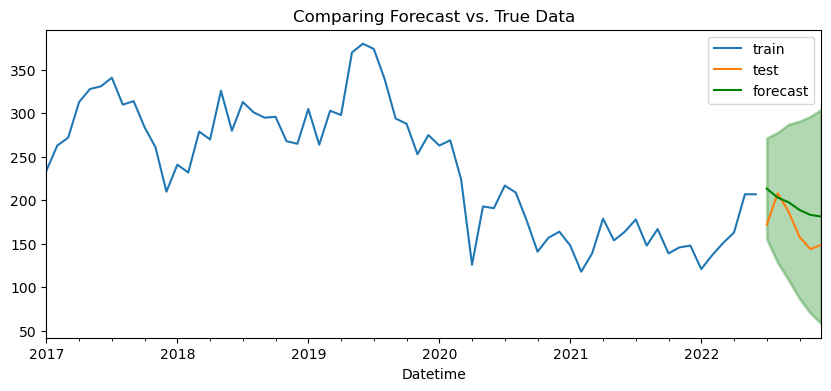

In [97]:
# Obtain forecast as a datatime with confidence intervals
forecast_df = guess_sarima.get_forecast(steps = len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics 
regression_metrics_ts(test, forecast_df['mean'])

- Still not a great model by any means, but it is the best I have.

#### Choosing Final Model

In [98]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

as_final_model = tsa.ARIMA(as_ts, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

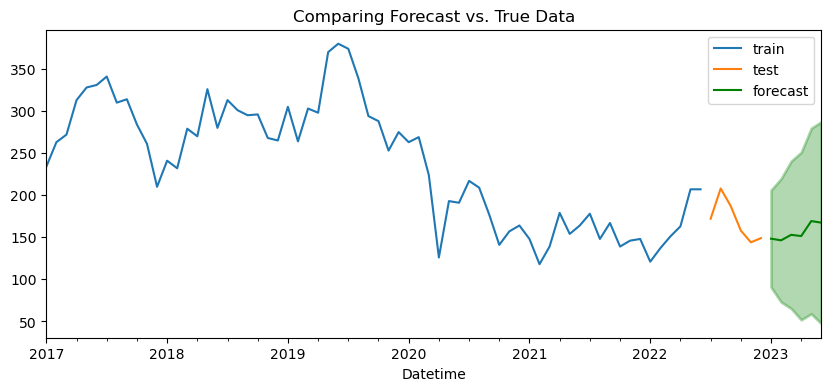

In [99]:
# Obtain future forecasts beyond test data
as_forecast_df  = as_final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,as_forecast_df);

### Comparing Data

#### Narcotics

In [100]:
# Starting narcotics counts
nar_starting_value = nar_forecast_df['mean'].iloc[0]
nar_starting_value

307.9514703523745

In [101]:
# final narcotics count
nar_final_value = nar_forecast_df['mean'].iloc[-1]
nar_final_value

338.6620656200912

In [102]:
# Flat change in assault
nar_change = nar_final_value - nar_starting_value
nar_change

30.710595267716712

In [103]:
# Percentage change for narcotics
nar_perc_change = (nar_change / nar_starting_value) * 100
nar_perc_change

9.972543801325582

#### Assault

In [104]:
# Starting assault count 
as_starting_value = as_forecast_df['mean'].iloc[0]
as_starting_value

148.3354884389676

In [105]:
# Final assault count
as_final_value = as_forecast_df['mean'].iloc[-1]
as_final_value

167.33762874765486

In [106]:
# Flat change in assault
as_change = as_final_value - as_starting_value
as_change

19.002140308687274

In [107]:
# Precentage change for assualt
as_perc_change = (as_change / as_starting_value) * 100
as_perc_change

12.810245551256386

### Analysis

- There are forecasted to be roughly 170 more narcotics arrests made in 6 months.
- Narcotics will see 30 more arrests made, compared to assaults having 19 more.
- Assaulst are going to have an overall larger percent increase in arrests.

## Analyzing Via Crime Location

### Time Series Modeling

In [108]:
# Resampling as yearly 
loc_month  = chicago_final.groupby('Location Description').resample('M').sum()['Arrest'].reset_index()
loc_month

Location Description   Datetime  Arrest
0      ABANDONED BUILDING/VACANT LOT 2001-01-31      39
1      ABANDONED BUILDING/VACANT LOT 2001-02-28      42
2      ABANDONED BUILDING/VACANT LOT 2001-03-31      50
3      ABANDONED BUILDING/VACANT LOT 2001-04-30      58
4      ABANDONED BUILDING/VACANT LOT 2001-05-31      67
...                              ...        ...     ...
10635                      WAREHOUSE 2022-08-31       1
10636                      WAREHOUSE 2022-09-30       1
10637                      WAREHOUSE 2022-10-31       2
10638                      WAREHOUSE 2022-11-30       2
10639                      WAREHOUSE 2022-12-31       1

[10640 rows x 3 columns]

In [109]:
# Pivoting the results to have datetime as the index.
loc_month_ts = loc_month.pivot(index = 'Datetime', columns = 'Location Description')
loc_month_ts.head()

Arrest                   \
Location Description ABANDONED BUILDING/VACANT LOT AIRPORT/AIRCRAFT   
Datetime                                                              
2001-01-31                                    39.0             65.0   
2001-02-28                                    42.0             78.0   
2001-03-31                                    50.0             84.0   
2001-04-30                                    58.0             61.0   
2001-05-31                                    67.0             72.0   

                                                         \
Location Description ALLEY/GROUNDS AUTO REPAIR BANK/ATM   
Datetime                                                  
2001-01-31                   206.0         3.0     61.0   
2001-02-28                   264.0         3.0     55.0   
2001-03-31                   326.0         2.0     72.0   
2001-04-30                   404.0         7.0     65.0   
2001-05-31                   418.0         3.0     72.0   

                                                                        \
Location Description BARBER SHOP/BEAUTY SALON BOAT/WATERCRAFT BUS STOP   
Datetime                                                                 
2001-01-31                                5.0             NaN      NaN   
2001-02-28                                6.0             1.0      NaN   
2001-03-31                                7.0             0.0      NaN   
2001-04-30                                4.0             1.0      NaN   
2001-05-31                                6.0             1.0      NaN   

                                                                         ...  \
Location Description CHURCH/SYNAGOGUE/PLACE OF WORSHIP COMMERCIAL STORE  ...   
Datetime                                                                 ...   
2001-01-31                                        14.0           1353.0  ...   
2001-02-28                                         9.0           1140.0  ...   
2001-03-31                                        12.0           1236.0  ...   
2001-04-30                                         4.0           1160.0  ...   
2001-05-31                                         6.0           1246.0  ...   

                                                                    \
Location Description RESTAURANT SCHOOL/COLLEGE/UNIVERSITY SIDEWALK   
Datetime                                                             
2001-01-31                154.0                     300.0   1031.0   
2001-02-28                143.0                     344.0   1074.0   
2001-03-31                134.0                     532.0   1104.0   
2001-04-30                140.0                     302.0   1245.0   
2001-05-31                141.0                     428.0   1283.0   

                                                                 \
Location Description SMALL VENDORS SPORTS ARENA/STADIUM  STREET   
Datetime                                                          
2001-01-31                     9.0                  5.0  4150.0   
2001-02-28                     5.0                  5.0  3629.0   
2001-03-31                     6.0                 12.0  4162.0   
2001-04-30                     7.0                 17.0  3828.0   
2001-05-31                     7.0                 11.0  3952.0   

                                                                  
Location Description TAVERN/LIQUOR STORE TRAIN VEHICLE WAREHOUSE  
Datetime                                                          
2001-01-31                         170.0  29.0   158.0      41.0  
2001-02-28                         148.0  22.0   177.0      23.0  
2001-03-31                         152.0  22.0   157.0      19.0  
2001-04-30                         130.0  24.0   169.0      33.0  
2001-05-31                         161.0  11.0   157.0      26.0  

[5 rows x 41 columns]

In [110]:
# Verifying the change went through as intended
loc_month_ts.columns

MultiIndex([('Arrest',     'ABANDONED BUILDING/VACANT LOT'),
            ('Arrest',                  'AIRPORT/AIRCRAFT'),
            ('Arrest',                     'ALLEY/GROUNDS'),
            ('Arrest',                       'AUTO REPAIR'),
            ('Arrest',                          'BANK/ATM'),
            ('Arrest',          'BARBER SHOP/BEAUTY SALON'),
            ('Arrest',                   'BOAT/WATERCRAFT'),
            ('Arrest',                          'BUS STOP'),
            ('Arrest', 'CHURCH/SYNAGOGUE/PLACE OF WORSHIP'),
            ('Arrest',                  'COMMERCIAL STORE'),
            ('Arrest',                 'CONSTRUCTION SITE'),
            ('Arrest',    'FACTORY/MANUFACTURING BUILDING'),
            ('Arrest',                      'FIRE STATION'),
            ('Arrest',               'GOVERNMENT BUILDING'),
            ('Arrest',        'HALLWAY/STAIRWELL/ELEVATOR'),
            ('Arrest',                'HIGHWAY/EXPRESSWAY'),
            ('Arrest',  

In [175]:
veh_ts = loc_month_ts['Arrest']
veh_ts = veh_ts['VEHICLE']
veh_ts

Datetime
2001-01-31    158.0
2001-02-28    177.0
2001-03-31    157.0
2001-04-30    169.0
2001-05-31    157.0
              ...  
2022-08-31     64.0
2022-09-30     42.0
2022-10-31     42.0
2022-11-30     51.0
2022-12-31     34.0
Name: VEHICLE, Length: 264, dtype: float64

- At a Quick glance it's apparent that crimes being reported in, and or related to vehicles, have dropped in recent years.
    - 2020 onward saw significant decrease in all reported crimes, but even before Covid-19 reported crimes were already on the decline.
- I will limit data used to 2012 onwards.

In [176]:
# Limiting the time series to 2012 onward.
veh_ts = veh_ts.loc['2012':]
veh_ts

Datetime
2012-01-31    229.0
2012-02-29    240.0
2012-03-31    224.0
2012-04-30    194.0
2012-05-31    178.0
              ...  
2022-08-31     64.0
2022-09-30     42.0
2022-10-31     42.0
2022-11-30     51.0
2022-12-31     34.0
Name: VEHICLE, Length: 132, dtype: float64

### Detemrining Correct Model

<Axes: xlabel='Datetime'>

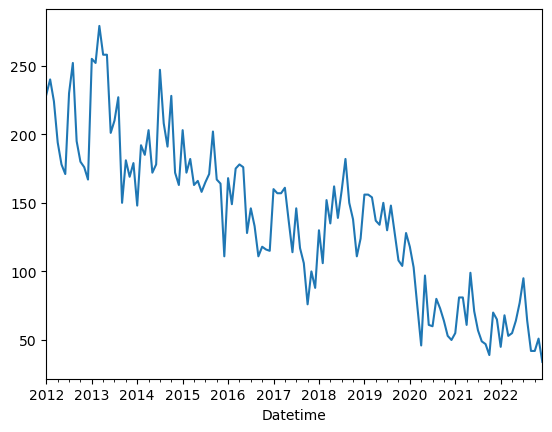

In [177]:
veh_ts.plot()

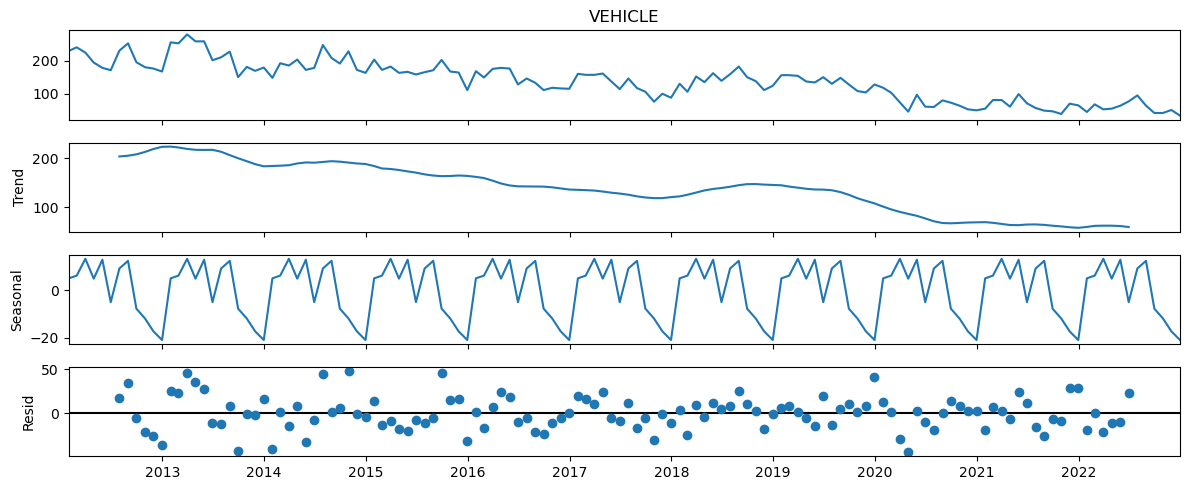

In [178]:
# We see a repeating pattern that is likely seasonal
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(veh_ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [179]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(nar_ts.max() - nar_ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 33.920833333333334 which is ~2.69% of the variation in time series.


- There doesn't appear to be any significant seasonality in vehicle related crimes reported over the years. 

In [180]:
# checking for nonseasonal differencing
ndiffs(veh_ts)

1

In [181]:
veh_ts_diff = veh_ts.diff().dropna()

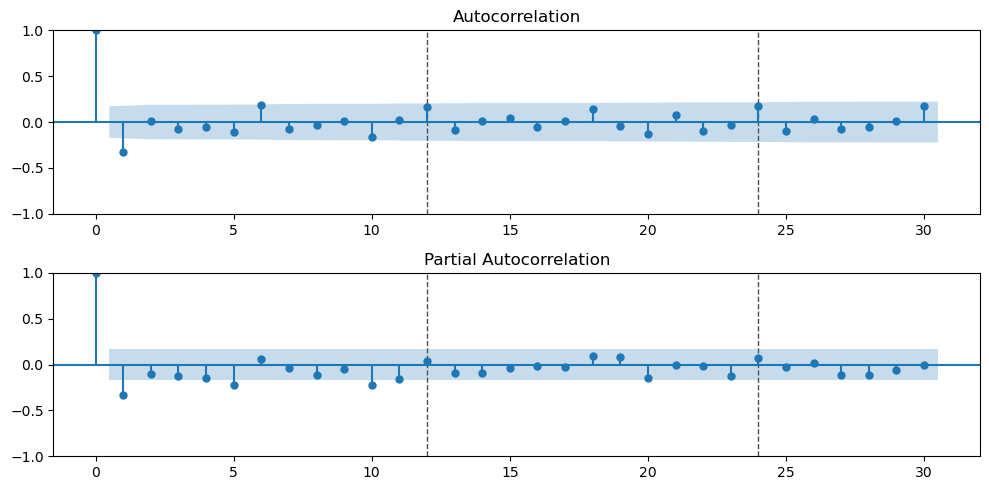

In [182]:
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(veh_ts_diff, annotate_seas=True, m = 12, nlags = 30);

- Both the autocorrelation and the partial autocorrelation gradually decrease, due to this I will start with (0,1,0).

#### Train Test Split

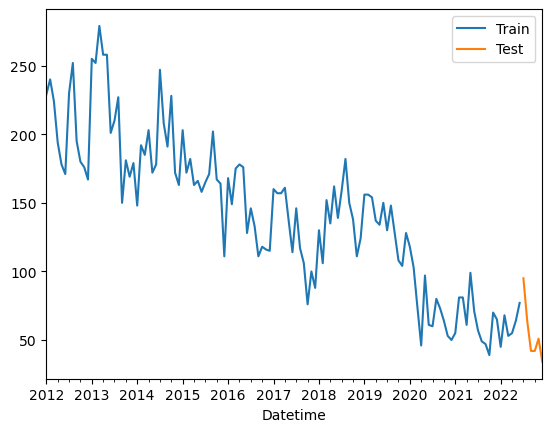

In [190]:
# tts so test size is 16 lags
test_lags = 6 
train, test = train_test_split(veh_ts, test_size= test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

#### Manual Model

In [191]:
# Trying assumed best fit
p = 0  # AR component 

d = 1  # Number of differencing required to make stationary

q =  0 # MA component 

# Define and fit the model
ar_2_ma_3_model = tsa.ARIMA(train, order=(p,d,q)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 28.333
- MSE = 911.333
- RMSE = 30.188
- R^2 = -1.209
- MAPE = 63.90%


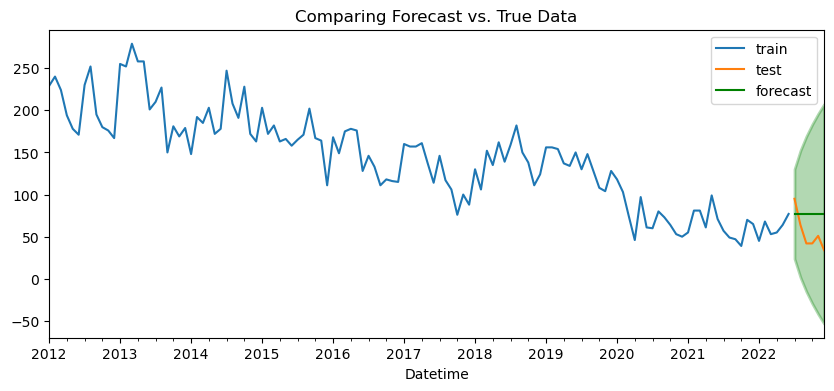

In [192]:
# Obtain summary of forecast as dataframe
forecast_df = ar_2_ma_3_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

- A MAPE value of 64% makes this suggests that this model will not be able to accurately predict the number of reported vehicle related crimes.
- Though, it's not enturely fair to strictly judge the model as the test data decreases unexpectedly making it very hard to predict without having more outside knowledge.

#### Auto ARIMA optimization

In [169]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=586.959, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=578.794, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=578.981, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=585.189, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=579.644, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=580.655, Time=0.13 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=580.732, Time=0.10 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=579.161, Time=0.06 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=586.525, Time=0.03 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=580.790, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=580.759, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=578.836, Time=0.06 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AI

In [170]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
print(auto_model.order)
print(auto_model.seasonal_order)

(1, 1, 0)
(1, 0, 0, 12)


In [153]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0 # nonseasonal MA
auto_arima = tsa.ARIMA(train, order = (p,d,q)).fit()

# Or instead of manually defining the orders, you can obtain them programmatically
# auto_sarima = tsa.ARIMA(train, order = auto_model.order, seasonal_order = auto_model.seasonal_order)

# Obtain model summary
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                VEHICLE   No. Observations:                   66
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -287.086
Date:                Thu, 10 Apr 2025   AIC                            578.172
Time:                        16:01:11   BIC                            582.521
Sample:                    01-31-2017   HQIC                           579.888
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3581      0.120     -2.975      0.003      -0.594      -0.122
sigma2       400.7851     91.930      4.360      0.000     220.606     580.964
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 2.72
Prob(Q):                              0.77   Prob(JB):                         0.26
Heteroskedasticity (H):               0.52   Skew:                             0.35
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

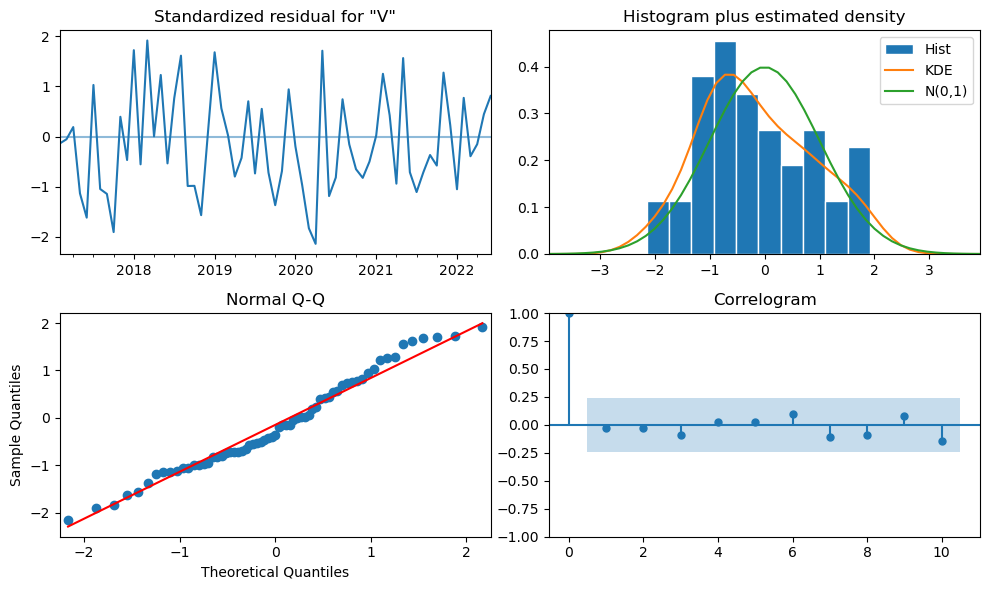

In [150]:
# Obtain diagnostic plots
fig = auto_arima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 26.307
- MSE = 779.323
- RMSE = 27.916
- R^2 = -0.889
- MAPE = 58.37%


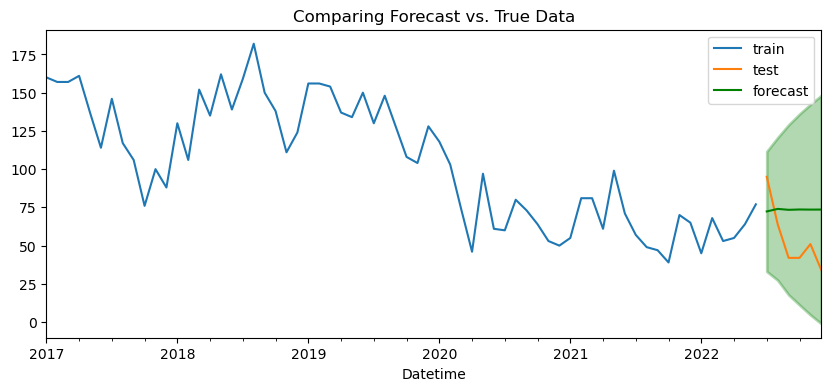

In [154]:
# Obtain summary of forecast as dataframe
forecast_df = auto_arima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

In [155]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0 # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                          VEHICLE   No. Observations:                   66
Model:             ARIMA(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -285.596
Date:                          Thu, 10 Apr 2025   AIC                            577.192
Time:                                  16:01:48   BIC                            583.715
Sample:                              01-31-2017   HQIC                           579.766
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3684      0.127     -2.896      0.004      -0.618      -0.119
ar.S.L12       0.2260      0.150      1.505      0.132      -0.068       0.520
sigma2       379.1041     83.413      4.545      0.000     215.617     542.591
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.67
Prob(Q):                              0.92   Prob(JB):                         0.26
Heteroskedasticity (H):               0.50   Skew:                             0.39
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

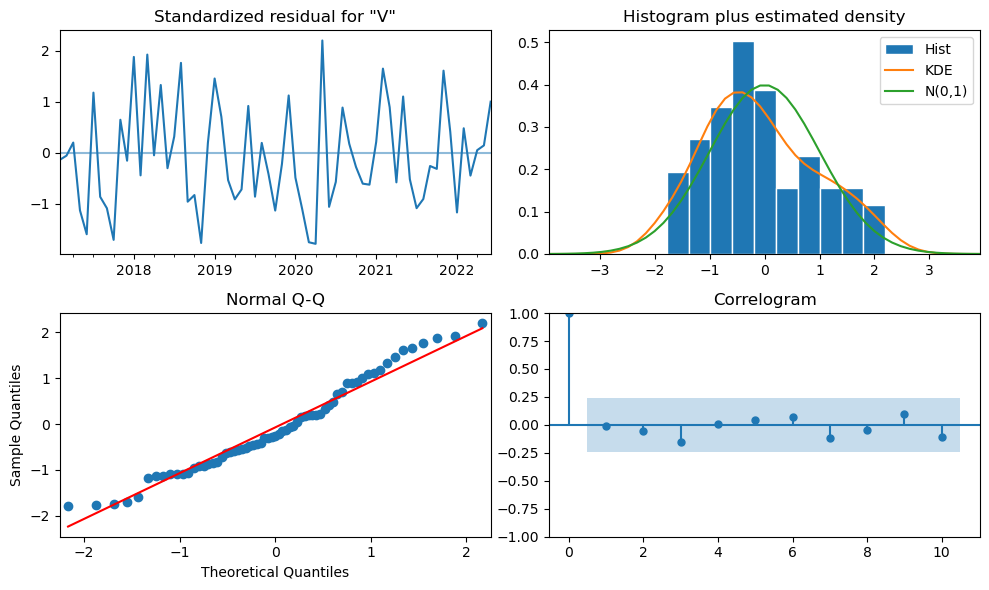

In [156]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 22.597
- MSE = 609.674
- RMSE = 24.692
- R^2 = -0.478
- MAPE = 49.02%


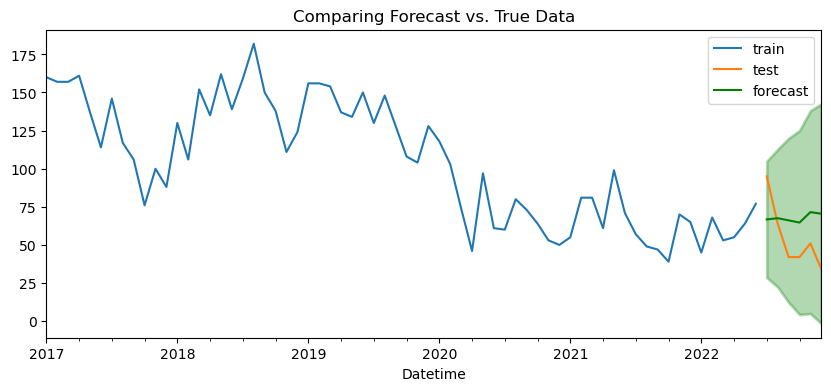

In [157]:
# Obtain forecast as a dataframe with confidence intervals
nar_forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, nar_forecast_df);
# Obtain metrics
regression_metrics_ts(test, nar_forecast_df['mean'])

- After trying a number of models I believe it will be very hard to accurately forecast the the test data. As there is a sharp down tick in vehicle related reported crimes.
- Although the model doesn't accurately predict the test data, it does appear to follow to apparent trend that was beginning to form.
- I will change the forecasted amount of time to 12 months instead of 6 to see if that will improve volatility.

##### Forecasting One Year

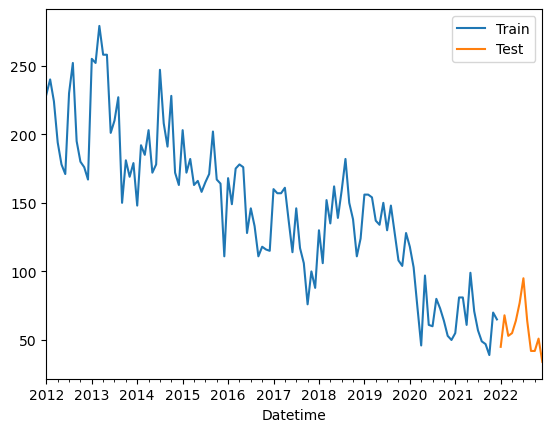

In [195]:
# tts so test size is 12 lags
test_lags = 12 
train, test = train_test_split(veh_ts, test_size= test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [196]:
# Trying assumed best fit
p = 0  # AR component 

d = 1  # Number of differencing required to make stationary

q =  0 # MA component 

# Define and fit the model
ar_2_ma_3_model = tsa.ARIMA(train, order=(p,d,q)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 15.000
- MSE = 326.167
- RMSE = 18.060
- R^2 = -0.208
- MAPE = 30.68%


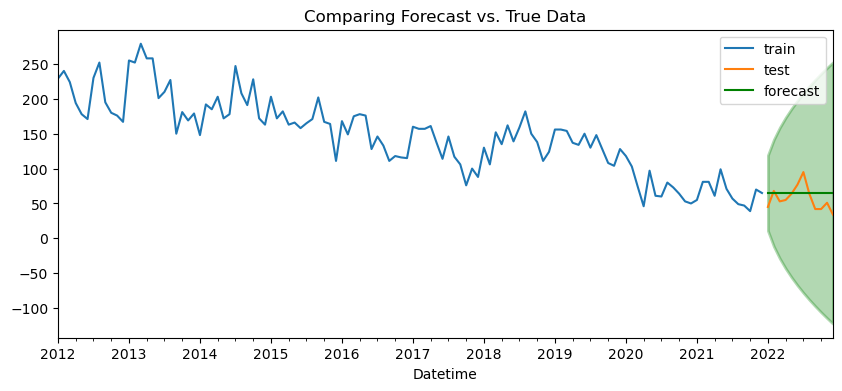

In [197]:
# Obtain summary of forecast as dataframe
forecast_df = ar_2_ma_3_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

- MAPE of 30% still isn't great by any means, but it is a significant improvement over prior models.
- I will go ahead with auto-arima modeling

In [198]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1131.043, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1116.329, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1114.902, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1129.340, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1115.707, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1109.521, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1114.049, Time=0.08 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=1111.319, Time=0.35 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1111.285, Time=0.30 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1114.747, Time=0.17 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1113.088, Time=0.16 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1125.356, Time=0.10 sec
 ARIMA(1,1,1)(1,0,1)[12] inte

In [199]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
print(auto_model.order)
print(auto_model.seasonal_order)

(2, 1, 1)
(1, 0, 1, 12)


In [200]:
# Orders for non seasonal components
p = 2 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1 # nonseasonal MA
auto_arima = tsa.ARIMA(train, order = (p,d,q)).fit()

# Or instead of manually defining the orders, you can obtain them programmatically
# auto_sarima = tsa.ARIMA(train, order = auto_model.order, seasonal_order = auto_model.seasonal_order)

# Obtain model summary
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                VEHICLE   No. Observations:                  120
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -552.817
Date:                Thu, 10 Apr 2025   AIC                           1113.634
Time:                        16:17:07   BIC                           1124.750
Sample:                    01-31-2012   HQIC                          1118.148
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4241      0.173      2.455      0.014       0.086       0.763
ar.L2          0.1219      0.120      1.014      0.311      -0.114       0.358
ma.L1         -0.8576      0.124     -6.918      0.000      -1.101      -0.615
sigma2       632.4938     81.384      7.772      0.000     472.985     792.003
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 4.40
Prob(Q):                              0.78   Prob(JB):                         0.11
Heteroskedasticity (H):               0.39   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

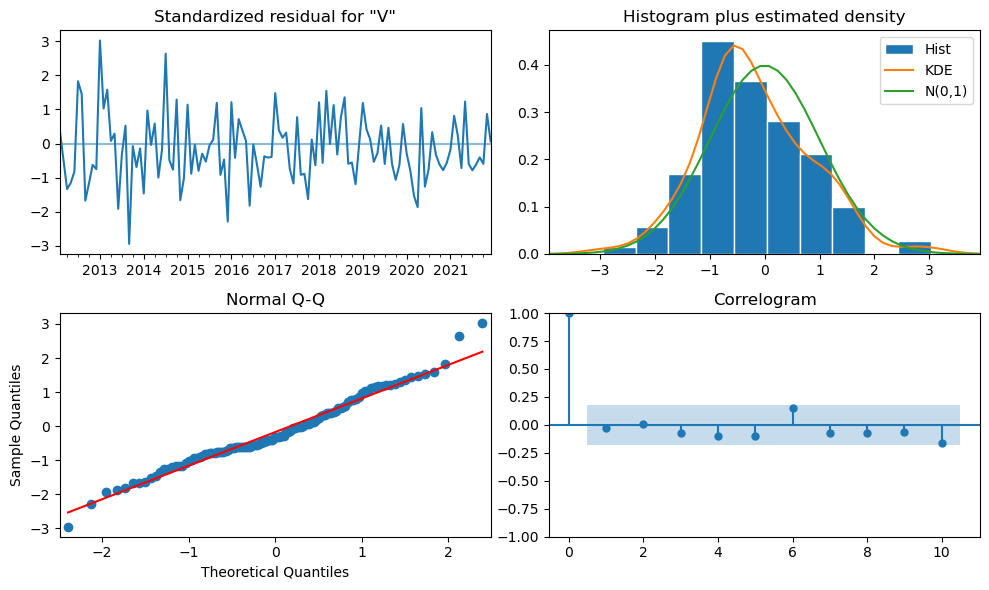

In [201]:
# Obtain diagnostic plots
fig = auto_arima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 14.809
- MSE = 321.641
- RMSE = 17.934
- R^2 = -0.192
- MAPE = 30.20%


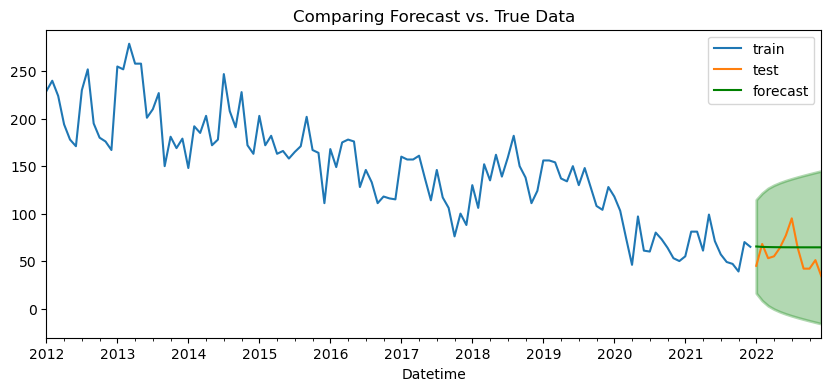

In [202]:
# Obtain summary of forecast as dataframe
forecast_df = auto_arima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

- Very slightly techinically better, but effectively no improvement.
- I will attempt a seasonal auto arima model

In [203]:
# Orders for non seasonal components
p = 2  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1 # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                          VEHICLE   No. Observations:                  120
Model:             ARIMA(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -546.823
Date:                          Thu, 10 Apr 2025   AIC                           1105.647
Time:                                  16:18:51   BIC                           1122.322
Sample:                              01-31-2012   HQIC                          1112.418
                                   - 12-31-2021                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4677      0.122      3.836      0.000       0.229       0.707
ar.L2          0.1830      0.122      1.495      0.135      -0.057       0.423
ma.L1         -0.9226      0.077    -11.936      0.000      -1.074      -0.771
ar.S.L12       0.9285      0.113      8.190      0.000       0.706       1.151
ma.S.L12      -0.7748      0.211     -3.674      0.000      -1.188      -0.361
sigma2       551.7868     77.112      7.156      0.000     400.650     702.923
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.88
Prob(Q):                              0.86   Prob(JB):                         0.39
Heteroskedasticity (H):               0.45   Skew:                             0.29
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

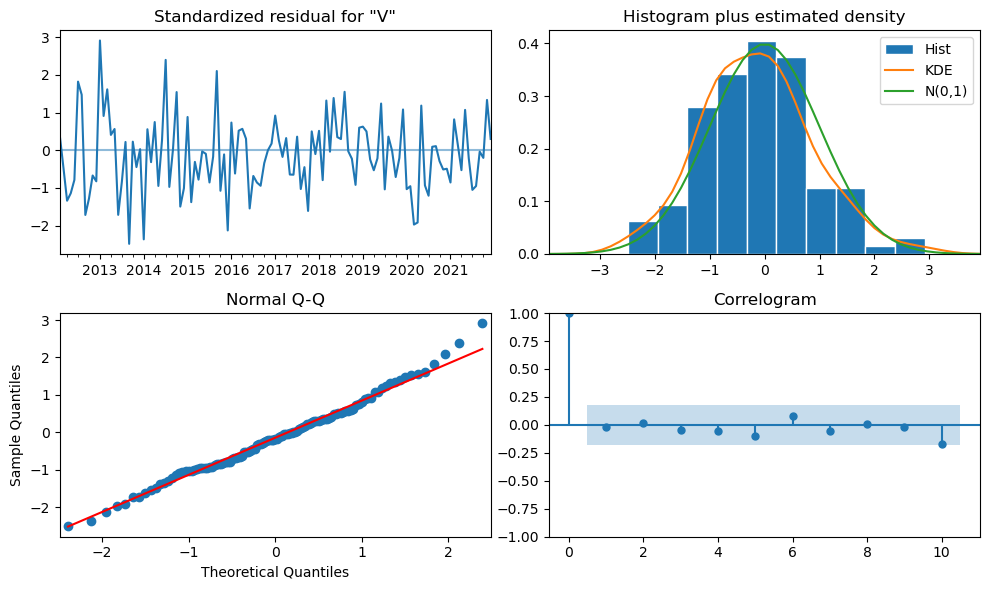

In [204]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 13.877
- MSE = 290.691
- RMSE = 17.050
- R^2 = -0.077
- MAPE = 25.53%


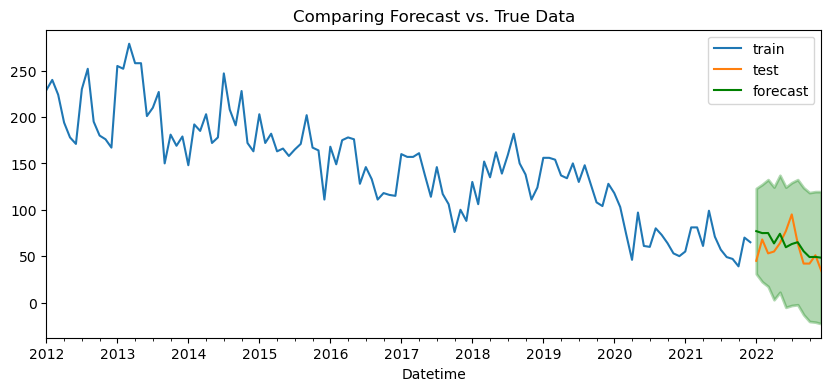

In [205]:
# Obtain forecast as a dataframe with confidence intervals
nar_forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, nar_forecast_df);
# Obtain metrics
regression_metrics_ts(test, nar_forecast_df['mean'])

- Now this is the first model that follows the overall trend of the test data. Still not a perfect model or anywhere close to being considered one, but definite progress

#### Guess and Check

In [ ]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

as_final_model = tsa.ARIMA(as_ts, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Final Thoughts

- I would recommend upping enforcement/awareness of all crimes over summer months.
- In most crimes May through August/September see the most arrests made.
    - Now this does raise a good question:
        - Since this data only records arrests, have they already upped enforcement in these months.
        - It could already be believed that crimes are seasonal so more cops are out, resulting in higer arrest rates.
        - There could possibly be an argument that the crimes are not seasonal, but the enforcement is.

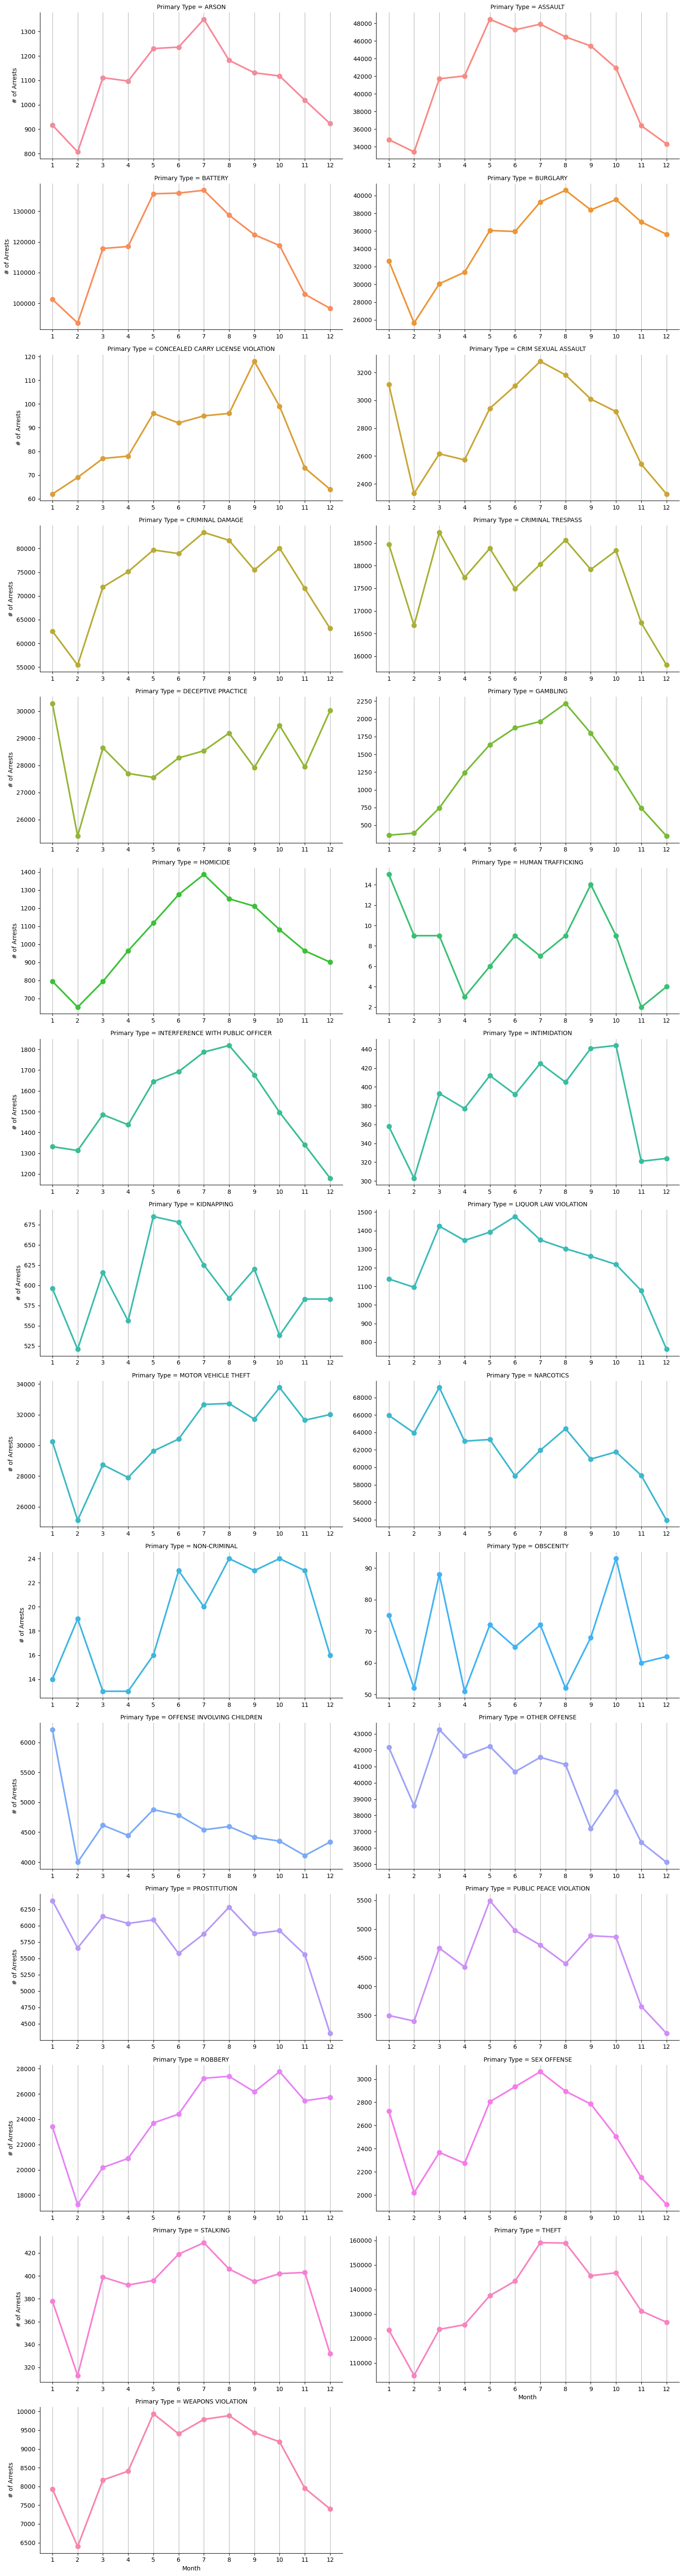

In [152]:
g = sns.catplot(data= crimes_by_month_df, x = 'Month', y = '# of Arrests',
                kind='point',aspect=2, height=4,
                hue='Primary Type', col='Primary Type',col_wrap=2,
               sharey=False, sharex=False)
[ax.grid(axis='x') for ax in g.axes];